# 1. 크롤링

## 1. 알라딘

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
import time
import pandas as pd

ModuleNotFoundError: ignored

In [ ]:
service = Service('chromedriver.exe')
driver = webdriver.Chrome(service = service)

In [ ]:
# CID : 카테고리(소설 : 1, 에세이 :55889 , 자기계발 : 336)
results = []

for page in range(1,21): # 페이지 입력
    url = "https://www.aladin.co.kr/shop/wbrowse.aspx?BrowseTarget=List&ViewRowsCount=50&ViewType=Detail\
    &PublishMonth=0&SortOrder=2&page={}&Stockstatus=0&PublishDay=84&CustReviewRankStart=0&CustReviewCountStart=0&PriceFilterMax=-1\
    &CID=1&SearchOption=".format(page)
    driver.get(url)
    time.sleep(2)
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    
    # 페이지에 있는 도서 링크(50개)
    book_links = soup.select('ul > li > a.bo3')
    links = []
    for book_link in book_links:
        a= book_link['href']
        links.append(a)
    for link in links:
        driver.get(link)
        time.sleep(2)
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        try:
            ISBN = soup.select('div.conts_info_list1 > ul > li')
            ISBN = ISBN[-1].text[-13:]
        except:
            pass

        #data = [ISBN]
        results.append(ISBN)

## 2. yes24

In [ ]:
re = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/book_col_keyword2.pkl')
re['isbn13'].to_pickle('/content/drive/MyDrive/도서추천시스템_2/isbn13.pkl')

In [ ]:
service = Service('chromedriver.exe')
driver = webdriver.Chrome(service = service)

In [ ]:
isbn13 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/isbn13.pkl')

In [ ]:
rank_mean = [] # 도서 평균 평점
rank_percentage = [] # 평균 percentage
review_title = [] # 리뷰 제목
review_id = [] # 리뷰 id
review_rank = [] # 리뷰 평점
review_text = [] # 리뷰 
isbn_idx = []


for isbn in isbn13: # 페이지 입력
    url = "http://www.yes24.com/product/search?query={}".format(isbn)
    driver.get(url)
    time.sleep(2)
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    
    # 페이지에 있는 도서 링크(50개)
    book_links = soup.select('a.gd_name')
    goods = []
    for link in book_links:
        a= link['href'].split('/')[3] 
        goods.append(a)
    for item in goods:
        del(goods[1:])
        driver.get('http://www.yes24.com'+'/Product/Goods/{}'.format(item)) # 상품 페이지
        time.sleep(1)
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        try:
            mean = soup.select('div.gd_rating > em.yes_b')[0].text
            rank_mean.append([mean]) # 도서 평균 평점
        except:
            mean = []
            rank_mean.append(mean) # 도서 평균 평점
        rank_p = []
        try:
            for k in range(5):
                rank_ = soup.select('span.barGraphBase')[k].text # 평점 percentage
                rank_p.append(rank_)
            rank_percentage.append(rank_p)
        except:
            rank_ = []
            rank_percentage.append(rank_)
        try:
            review_t = []  # 각각의 책의 리뷰제목 리스트
            review_i = []
            review_r = []
            review_te = []
            for page in range(1,3): # 리뷰 페이지 2개
                driver.get('http://www.yes24.com/Product/communityModules/GoodsReviewList/{}?Type=ALL&_=1648001707174&Sort=2&PageNumber={}'.format(item, page))
                time.sleep(1)
                html = driver.page_source
                soup = BeautifulSoup(html, 'html.parser')
                
                blog_link = []
                for i in range(5): # 리뷰 한 페이지에 있는 5개 리뷰 가져오기
                    try:
                        title = soup.select('span.review_tit')[i].text.strip() # 리뷰 제목
                        review_t.append(title)
                        r_id = soup.select('a.lnk_id')[i].text # 리뷰 id
                        review_i.append(r_id)
                        rank = soup.select('span.review_rating')[i].text.split('\n')[1][-2:] # 리뷰 평점
                        review_r.append(rank)
                        blog_l = soup.select('div.review_lnk a')[i]['href'] # 리뷰 블로그 링크
                        blog_link.append(blog_l)
                    except:
                        pass
                for j in range(5): # 리뷰 한 페이지에 있는 5개 블로그 내용 가져오기
                        driver.get(blog_link[j]) # 리뷰 블로그 링크 들어가기
                        time.sleep(1)
                        html = driver.page_source
                        soup = BeautifulSoup(html, 'html.parser')
                        text = soup.select('div.blogContArea')[0].text # 리뷰 내용 
                        review_te.append(text)
        except:
            pass
        review_title.append(review_t)
        review_id.append(review_i)
        review_rank.append(review_r)
        review_text.append(review_te)
        isbn_idx.append(isbn)

In [ ]:
col = ['rank_mean','rank_percentage','review_title','review_id','review_rank','review_text']
user = pd.DataFrame([rank_mean,rank_percentage,review_title,review_id,review_rank,review_text]).T
user.columns = col
user

In [ ]:
#user.to_pickle('user', protocol = 4)

# 2. API 조회하기

In [ ]:
import requests
import pandas as pd
import json

In [ ]:
# API 호출키
KEY = '**************'

In [ ]:
url_look_list = []

for isbn in results:
    url_look = 'https://www.aladin.co.kr/ttb/api/ItemLookUp.aspx?ttbkey={}&itemIdType=isbn13&ItemId={}&output=JS&Version=20131101&OptResult=authors,reviewList,fulldescription,fulldescription2,Story,categoryIdList'.format(KEY, isbn)
    url_look_list.append(url_look)
print(url_look_list)

In [ ]:
items = []
lists = []
for url_look in url_look_list:
    try:
        response = requests.get(url_look)
        text = json.loads(response.text)
        #time.sleep(1)
        title = text['item'][0]['title']
        author = text['item'][0]['author']
        pubDate = text['item'][0]['pubDate']
        description = text['item'][0]['description']
        isbn13 = text['item'][0]['isbn13']
        categoryID = text['item'][0]['categoryId']
        categoryName = text['item'][0]['categoryName']
        salesPoint = text['item'][0]['salesPoint']
        adult = text['item'][0]['adult']
        rank = text['item'][0]['customerReviewRank']
        fullDes = text['item'][0]['fullDescription']
        fullDes2 = text['item'][0]['fullDescription2']
        story = text['item'][0]['subInfo']['story']
        try:
            reviewrank = text['item'][0]['reviewList'][0]['reviewRank']
            reviewtitle = text['item'][0]['reviewList'][0]['title']
            review_w = text['item'][0]['reviewList'][0]['writer']
        except:
            reviewrank = 0
            reviewtitle = 0
            review_w = 0
        lists.append([title, author, pubDate, description,isbn13,categoryID,categoryName,salesPoint,adult,rank,fullDes,fullDes2,story,reviewrank,reviewtitle,review_w])
    except:
        pass
cols = ['title', 'author', 'pubDate','description','isbn13','categoryID','categoryName','salesPoint','adult','rank','fullDes','fullDes2','story','reviewrank','reviewtitle','review_w']
df = pd.DataFrame(lists, columns = cols)

In [ ]:
import pickle
df.to_pickle('essay.plk')

# 3. 크롤링 및 API 데이터 통합

In [ ]:
data1 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/data.pkl')
essay = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/essay.pkl')
essay_39 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/essay_39-56.pkl')
essay_57 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/essay_57-80.pkl')
essay_81 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/essay_81-100.pkl')
essay_101 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/essay_101-120.pkl')
essay_121 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/essay_121-140.pkl')
essay_141 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/essay_141-160.pkl')
essay_161 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/essay_161-180.pkl')
essay_181 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/essay_181-200.pkl')
essay_201 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/essay_201-225.pkl')
essay_226 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/essay_226-250.pkl')
essay_251 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/essay_251-300.pkl')
novel_1 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_1-20.pkl')
novel_21 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_21-40.pkl')
novel_41 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_41-60.pkl')
novel_61 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_61-80.pkl')
novel_81 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_81-100.pkl')
novel_101 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_101-120.pkl')
novel_121 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_121-140.pkl')
novel_141 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_141-160.pkl')
novel_161 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_161-180.pkl')
novel_181 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_181-200.pkl')
novel_201 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_201-220.pkl')
novel_221 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_221-240.pkl')
novel_241 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_241-260.pkl')
novel_261 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_261-280.pkl')
novel_281 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_281-300.pkl')
novel_301 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_301-320.pkl')
novel_321 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_321-340.pkl')
novel_341 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_341-360.pkl')
novel_361 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_361-380.pkl')
novel_381 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_381-400.pkl')
novel_401 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_401-420.pkl')
novel_421 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_421-440.pkl')
novel_441 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_441-460.pkl')
novel_461 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_461-480.pkl')
novel_481 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_481-500.pkl')
novel_501 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_501-526.pkl')
novel_527 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_527-600.pkl')
novel_601 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_601-650_.pkl')
novel_651 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_651-700.pkl')
novel_701 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_701-800.pkl')
novel_801 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_801-850.pkl')
novel_851 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_851-900.pkl')
novel_901 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_901-950.pkl')
novel_951 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_951-1000.pkl')
novel_1001 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/novel_1001-1017.pkl')
selfhelp_1 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/selfhelp_1-20.pkl')
selfhelp_21 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/selfhelp_21-40.pkl')
selfhelp_41 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/selfhelp_41-70.pkl')
selfhelp_71 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/selfhelp_71-100.pkl')

In [ ]:
data = pd.concat([data1, essay,essay_39,essay_57,essay_81,essay_101,essay_121,essay_141,essay_161,essay_181,essay_201,essay_226,essay_251,
                  novel_1, novel_21,novel_41,novel_61,novel_81,novel_101,novel_121,novel_141,novel_161,novel_181,
                  novel_201,novel_221,novel_241,novel_261,novel_281,novel_301,
                  novel_321,novel_341,novel_361,novel_381,novel_401,novel_421,novel_441,novel_461,novel_481,
                  novel_501,novel_527,novel_601,novel_651,novel_701,novel_801,novel_851,novel_901,novel_951,novel_1001,
                  selfhelp_1,selfhelp_21,selfhelp_41,selfhelp_71], ignore_index=True)
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70206 entries, 0 to 71638
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         70206 non-null  object
 1   author        70206 non-null  object
 2   pubDate       70206 non-null  object
 3   description   70206 non-null  object
 4   isbn13        70206 non-null  object
 5   categoryID    70206 non-null  int64 
 6   categoryName  70206 non-null  object
 7   salesPoint    70206 non-null  int64 
 8   adult         70206 non-null  bool  
 9   rank          70206 non-null  int64 
 10  fullDes       70206 non-null  object
 11  fullDes2      70206 non-null  object
 12  story         70206 non-null  object
 13  reviewrank    70206 non-null  int64 
 14  reviewtitle   70206 non-null  object
 15  review_w      70206 non-null  object
dtypes: bool(1), int64(4), object(11)
memory usage: 8.6+ MB


In [ ]:
data.to_pickle('/content/drive/MyDrive/도서추천시스템/data/크롤링 및 API 불러오기/book.pkl', protocol=4)

# 4. 자연어

# 4-1. 전처리

In [ ]:
## Mecab 설치

!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 448 kB 50.1 MB/s 
Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 109 (delta 7), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (109/109), 1.27 MiB | 10.08 MiB/s, done.
Resolving deltas: 100% (46/46), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-03-29 01:07:45--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c0:3470, 2406:da00:ff00::6b17:d1f5, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import pickle

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt

In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/book.pkl')
data.head(3)

,title,author,pubDate,description,isbn13,categoryID,categoryName,salesPoint,adult,rank,fullDes,fullDes2,story,reviewrank,reviewtitle,review_w
0,자기만의 방,"버지니아 울프 (지은이), 최설희 (옮긴이)",2022-03-10,,9791190710343,51373,국내도서>에세이>외국에세이,0,False,0,시대를 뛰어넘어 진정한 페미니즘 비평의 장을 연 고전. 거턴 대학과 뉴넘 대학에서 ...,<b>자유로운 삶을 꿈꾸는 모든 여성들에게 전하는 창조적 삶의 영감<BR>시대를 뛰...,,0,0,0
1,오만과 편견,"제인 오스틴 (지은이), 이신 (옮긴이)",2022-03-10,"앤의서재 여성작가 클래식 2권. 지금으로부터 200년 전, 여자가 글을 쓰는 것도 ...",9791190710350,50919,국내도서>소설/시/희곡>영미소설,0,False,0,"앤의서재 여성작가 클래식 2권. 지금으로부터 200년 전, 여자가 글을 쓰는 것도 ...","<b>여성의 삶과 사랑, 결혼에 대한 날카로운 통찰과 분석!<BR>200년간 전 세...",,0,0,0
2,프랑켄슈타인,"메리 셸리 (지은이), 김나연 (옮긴이)",2022-03-10,인류를 구할 수 있다는 ‘오만한’ 열망에 사로잡혀 연구와 실험을 거듭하고 끝내 새로...,9791190710367,50919,국내도서>소설/시/희곡>영미소설,0,False,0,"영국 「옵저버」, 미국 「뉴스위크」가 ‘역대 최고의 소설 100’에 선정한 명저이자...",,,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70206 entries, 0 to 71638
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         70206 non-null  object
 1   author        70206 non-null  object
 2   pubDate       70206 non-null  object
 3   description   70206 non-null  object
 4   isbn13        70206 non-null  object
 5   categoryID    70206 non-null  int64 
 6   categoryName  70206 non-null  object
 7   salesPoint    70206 non-null  int64 
 8   adult         70206 non-null  bool  
 9   rank          70206 non-null  int64 
 10  fullDes       70206 non-null  object
 11  fullDes2      70206 non-null  object
 12  story         70206 non-null  object
 13  reviewrank    70206 non-null  int64 
 14  reviewtitle   70206 non-null  object
 15  review_w      70206 non-null  object
dtypes: bool(1), int64(4), object(11)
memory usage: 8.6+ MB


In [ ]:
#from eunjeon import Mecab

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

In [ ]:
df = data.copy()

## 1. content 수정
- author, categoryName 컬럼 정제
- text 컬럼 추가

- categoryName 소설, 시, 희곡 분리
 

In [ ]:
# 작가 이름..(지은이)앞까지
authors = []
for author in df['author']:
    a = author.split('(')[0]
    authors.append(a)

In [ ]:
df['author'] = authors

In [ ]:
# categoryName..두번째 카테고리명만
catagories = []
for category in df['categoryName']:
    try:
        b = category.split('>')[1]
    except:
        b = category.split('>')[0]
    catagories.append(b)

In [ ]:
df['categoryName'] = catagories

In [ ]:
# 카테고리 추출(cat)
cat = ['소설/시/희곡', '에세이', '자기계발']

df = df[df['categoryName'].isin(cat)]
df

In [ ]:
for i in range(len(df)):
    try:
        if (df['fullDes'][i] == '') & (df['fullDes2'][i] == ''):
            df = df.drop(index = i)
    except:
        pass

In [ ]:
df['reviewtitle'].replace(0,'', inplace=True)
df['text'] = df['description'] + df['fullDes'] + df['fullDes2'] + df['reviewtitle']

In [ ]:
df['text'] 

0        시대를 뛰어넘어 진정한 페미니즘 비평의 장을 연 고전. 거턴 대학과 뉴넘 대학에서 ...
1        앤의서재 여성작가 클래식 2권. 지금으로부터 200년 전, 여자가 글을 쓰는 것도 ...
2        인류를 구할 수 있다는 ‘오만한’ 열망에 사로잡혀 연구와 실험을 거듭하고 끝내 새로...
17       신선의 행적과 장생불사를 다룬 신선설화집이자 신선전기집이다. 도교의 주요 경전으로 ...
19       사회·역사·문학과 개인의 관계를 예리한 감각으로 관찰하며 가공도 은유도 없는 독보적...
                               ...                        
71633    대한민국 최고의 정신과 의사이자 뇌과학자인 이시형 박사가 한국인 뇌피로의 실체와 해...
71634    20년 경력의 배우이자 글쓰기 강의로 유명한 저자 명로진은 일, 가오, 눈물, 권력...
71636    그리스 신화와 고전을 통해 자기실현ㆍ자기혁명의 지혜를 찾는 책이다. 그리스와 근동 ...
71637             [100자평]승리 유전자, 자동 목적 달성 장치,오래된 뇌, 말의 ...
71638    '칭찬'과 '비난', '낙관'과 '비관'을 주제로, 우리가 관계 맺고 있는 수많은 ...
Name: text, Length: 54976, dtype: object

In [ ]:
#df.to_pickle('book1.pkl', protocol=4)

In [ ]:
df1 = df.copy()
df1.columns

Index(['title', 'author', 'pubDate', 'description', 'isbn13', 'categoryID',
       'categoryName', 'salesPoint', 'adult', 'rank', 'fullDes', 'fullDes2',
       'story', 'reviewrank', 'reviewtitle', 'review_w', 'text'],
      dtype='object')

In [ ]:
df1 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/book1.pkl')

In [ ]:
df1.head(3)

,title,author,pubDate,description,isbn13,categoryID,categoryName,salesPoint,adult,rank,fullDes,fullDes2,story,reviewrank,reviewtitle,review_w,text
0,자기만의 방,버지니아 울프,2022-03-10,,9791190710343,51373,에세이,0,False,0,시대를 뛰어넘어 진정한 페미니즘 비평의 장을 연 고전. 거턴 대학과 뉴넘 대학에서 ...,<b>자유로운 삶을 꿈꾸는 모든 여성들에게 전하는 창조적 삶의 영감<BR>시대를 뛰...,,0,,0,시대를 뛰어넘어 진정한 페미니즘 비평의 장을 연 고전. 거턴 대학과 뉴넘 대학에서 ...
1,오만과 편견,제인 오스틴,2022-03-10,"앤의서재 여성작가 클래식 2권. 지금으로부터 200년 전, 여자가 글을 쓰는 것도 ...",9791190710350,50919,소설/시/희곡,0,False,0,"앤의서재 여성작가 클래식 2권. 지금으로부터 200년 전, 여자가 글을 쓰는 것도 ...","<b>여성의 삶과 사랑, 결혼에 대한 날카로운 통찰과 분석!<BR>200년간 전 세...",,0,,0,"앤의서재 여성작가 클래식 2권. 지금으로부터 200년 전, 여자가 글을 쓰는 것도 ..."
2,프랑켄슈타인,메리 셸리,2022-03-10,인류를 구할 수 있다는 ‘오만한’ 열망에 사로잡혀 연구와 실험을 거듭하고 끝내 새로...,9791190710367,50919,소설/시/희곡,0,False,0,"영국 「옵저버」, 미국 「뉴스위크」가 ‘역대 최고의 소설 100’에 선정한 명저이자...",,,0,,0,인류를 구할 수 있다는 ‘오만한’ 열망에 사로잡혀 연구와 실험을 거듭하고 끝내 새로...
17,[큰글씨책] 원서발췌 신선전,갈홍,2022-03-28,신선의 행적과 장생불사를 다룬 신선설화집이자 신선전기집이다. 도교의 주요 경전으로 ...,9791128858338,50923,소설/시/희곡,0,False,0,동진의 갈홍이 지은 <신선전>. 신선의 행적과 장생불사를 다룬 신선설화집이자 신선전...,,,0,,0,신선의 행적과 장생불사를 다룬 신선설화집이자 신선전기집이다. 도교의 주요 경전으로 ...
19,집착,아니 에르노,2022-03-18,사회·역사·문학과 개인의 관계를 예리한 감각으로 관찰하며 가공도 은유도 없는 독보적...,9788954685603,50921,소설/시/희곡,0,False,0,‘직접 체험하지 않은 허구를 쓴 적은 한 번도 없고 앞으로도 그럴 것’이라는 선언으...,,,0,,0,사회·역사·문학과 개인의 관계를 예리한 감각으로 관찰하며 가공도 은유도 없는 독보적...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71633,뇌력혁명 - 뇌피로가 풀려야 인생이 풀린다!,이시형,2013-11-01,대한민국 최고의 정신과 의사이자 뇌과학자인 이시형 박사가 한국인 뇌피로의 실체와 해...,9791185020136,70239,자기계발,281,False,9,대한민국 최고의 정신과 의사이자 뇌과학자인 이시형 박사가 한국인 뇌피로의 실체와 해...,<b>활력 잃고 방황하는 한국인에게 건네는 이시형 박사의 인생 처방전!</b><BR...,,2,[마이리뷰]기대도 안했지만,mcatcher,대한민국 최고의 정신과 의사이자 뇌과학자인 이시형 박사가 한국인 뇌피로의 실체와 해...
71634,남자의 교과서 - 여자는 전혀 모르고 남자는 차마 말 못하는 것들,명로진,2013-04-05,"20년 경력의 배우이자 글쓰기 강의로 유명한 저자 명로진은 일, 가오, 눈물, 권력...",9788997838127,3812,자기계발,281,False,9,남자들은 언제나 갑의 눈치를 보며 끊임없는 술자리에 위장을 버리면서도 ‘일’이 가장...,<b>남자들은 지금 최선을 다하고 있다!<BR>\n상사와 갑을 위해 웃음을 다 써버...,,8,[마이리뷰]남자의 교과서,남희돌이,"20년 경력의 배우이자 글쓰기 강의로 유명한 저자 명로진은 일, 가오, 눈물, 권력..."
71636,그리스 신전에서 인간의 길을 묻다 - 내 인생을 바꾸는 4천 년의 지혜,스티븐 버트먼,2011-12-19,그리스 신화와 고전을 통해 자기실현ㆍ자기혁명의 지혜를 찾는 책이다. 그리스와 근동 ...,9788956591858,70216,자기계발,281,False,8,그리스 신화와 고전을 통해 자기실현ㆍ자기혁명의 지혜를 찾는 책이다. 그리스와 근동 ...,"매장된 도시와 버려진 사원의 잔해, 부서져가는 필사본에 담긴 채 4천 년의 세월을 ...",,8,[100자평]자신의 미숙함을 고민하는 청소년 혹은 20대 청년에게 ...,bright,그리스 신화와 고전을 통해 자기실현ㆍ자기혁명의 지혜를 찾는 책이다. 그리스와 근동 ...
71637,성공을 부르는 긍정의 힘,사토 도미오,2006-05-25,,9788987794938,70216,자기계발,281,False,7,,,,4,"[100자평]승리 유전자, 자동 목적 달성 장치,오래된 뇌, 말의 ...",Friday,"[100자평]승리 유전자, 자동 목적 달성 장치,오래된 뇌, 말의 ..."


In [ ]:
# categoryName 소설/시/희곡 -> 소설, 시, 희곡

# recommend.pkl 데이터프레임 불러오기
df = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/recommend.pkl')

In [ ]:
# 한국시 51169
# 신춘문예[50942, 56559] 없음..
for i in range(len(df)):
    if (df['categoryID'][i] == 50942):
        print(i)

In [ ]:
poem_id = [50940, 69256,51170,51169,51172,51173,51168,51171,51167,51175,
         51177,97457,103752,103753,103754,103755,103756,103757,103758,
         103759,103760,103761,103762,103763,103764,103765,103766,103767,
         103768,103769,103770,103771,105329,105330,105331,105332,105333,
         105334,105335,103772,103773,103774,56558,74436,57774,57773,57776,
         57777,57772,57775,57771]
play_id = [50948,51212,51210,56563,57809,57808,103778,103779,103780,103781,103782,103783,
         103784,103785,103786,103787,103788,103789,103790,103791,
         103792,103793,103794,103795,103796,56563,57809,57808]         

In [ ]:
# df를 문학 아닌 것(에세이, 자기계발), 문학인 것 나누기
nonlit = ['에세이', '자기계발']
df_nonlit = df[df['categoryName'].isin(nonlit)]
print(len(df_nonlit))

lit = ['소설/시/희곡']
df_lit = df[df['categoryName'].isin(lit)]
print(len(df_lit))

14908
40068


In [ ]:
df_lit = df_lit.reset_index(drop=True) # 인덱스정리
poem_list = []
play_list = []
novel_list = []
for i in range(len(df_lit)) :
    if df_lit['categoryID'][i] in poem_id:
        poem_list.append(df_lit['categoryID'][i])
        df_lit['categoryName'][i] = '시'
    elif df_lit['categoryID'][i] in play_id:
        play_list.append(df_lit['categoryID'][i])
        df_lit['categoryName'][i] = '희곡'
    else:
        novel_list.append(df_lit['categoryID'][i])
        df_lit['categoryName'][i] = '소설'

df_lit.tail()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,isbn13,title,categoryID,categoryName,salesPoint,adult,rank,genres,mood,interest
40063,9788954101103,한국 현대시와 종교,51300,소설,20,False,0,[],[],[]
40064,9788957630112,소녀 늑대 소굴에 들어가다 1,51125,소설,20,False,0,[],[],[친구]
40065,9788988395769,보들레르를 찾아서,51325,소설,20,False,0,[],[],[]
40066,9788989291688,내 작은 섬까지 그가 왔다,51167,시,20,False,0,[],[],[]
40067,9788989692164,젊은 베르테르의 슬픔 - 세계명작 바로읽기 5,50922,소설,20,False,0,[],[],[]


In [ ]:
print(len(poem_list))
print(len(play_list))
print(len(novel_list))

In [ ]:
# 다시 하나의 df로 통합
df = pd.concat([df_lit, df_nonlit], ignore_index=True)
len(df)

54976

In [ ]:
#df.to_pickle('./recommend_cat.pkl', protocol=4)

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/recommend_cat.pkl')
df.tail(100)

,isbn13,title,categoryID,categoryName,salesPoint,adult,rank,genres,mood,interest
54876,9791196299859,나는 내일 어제의 나와 만난다,70215,자기계발,296,False,9,[시대],"[고통, 슬픔, 비극, 절망, 불행, 위로, 희망, 행복, 힐링, 긍정, 열망, 용기]","[생각, 심리, 관계, 청춘, 인생, 시간]"
54877,8809990040711,나도 작가 노트 - 글쓰기 노트,70223,자기계발,296,False,10,[],"[행복, 고민, 후회]","[일기, 심리, 생각, 시간, 인생]"
54878,9788985817929,헐 머니가 온다 - 60에 시작한 억대 연봉 강사,70215,자기계발,295,False,10,[동화],"[긍정, 희망, 슬픔, 행복, 도전, 열정, 열망]","[생각, 일상, 성공, 인생, 취업, 사랑, 청춘]"
54879,9791191636017,"결국엔, 콘텐츠 - 어느 예능 PD의 K콘텐츠 도전기",70216,자기계발,295,False,10,"[시대, 전쟁]","[불행, 열정, 행복, 도전]","[영화, 사랑, 인생, 청춘, 성공, 설득, 생각]"
54880,9791197228223,오늘부터 행복한 사람이 되는 법을 가르쳐드립니다,70211,자기계발,295,False,9,[동화],"[열정, 도전, 행복, 위로, 긍정, 고민, 우울, 불안, 고통, 슬픔, 후회, 자...","[심리, 관계, 사랑, 생각, 인생, 청춘, 시간, 일상, 성공]"
...,...,...,...,...,...,...,...,...,...,...
54971,9791185020136,뇌력혁명 - 뇌피로가 풀려야 인생이 풀린다!,70239,자기계발,281,False,9,"[과학, 시대]","[행복, 우울, 불안, 고민, 긍정]","[사회, 일상, 인간, 인생, 청춘, 시간]"
54972,9788997838127,남자의 교과서 - 여자는 전혀 모르고 남자는 차마 말 못하는 것들,3812,자기계발,281,False,9,[동화],"[슬픔, 행복, 고민, 후회]","[정치, 관계, 생각, 인생, 가족, 친구, 시간]"
54973,9788956591858,그리스 신전에서 인간의 길을 묻다 - 내 인생을 바꾸는 4천 년의 지혜,70216,자기계발,281,False,8,"[예술, 시대, 판타지, 동화]","[열정, 도전, 용기, 행복]","[성공, 인간, 인생, 청춘, 일상]"
54974,9788987794938,성공을 부르는 긍정의 힘,70216,자기계발,281,False,7,[],[],[성공]


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

##2. 불용어 제거

In [ ]:
df1['text'] = df1['text'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


## 3. 토큰화
- 형태소 기반 토큰화 -> mecab

In [ ]:
results = []

for i in df1['text']:
    fullDes = mecab.pos(i)
    words_all = []
    for j in fullDes:
        
        if (j[1] == 'NNG') | (j[1] == 'NNP'):
            words_all.append(j[0])
    results.append(words_all)

In [ ]:
# Series 타입으로 변환 후 저장
# results_S = pd.Series(results)
# results_S.to_pickle('/content/drive/MyDrive/도서추천시스템_2/results.pkl', protocol=4)

# 타입을 list로 변환해 사용
# results = list(pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/results.pkl'))

# 4-2. 모델링

## 1. Word2Vec

In [ ]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from matplotlib import font_manager as fm
from matplotlib import rc

In [ ]:
book_word2vec = Word2Vec(results, min_count=1)

In [ ]:
# 유사한 단어 30개 확인
book_word2vec.wv.most_similar("자연",topn=30)

#4-3. 키워드 분리
- 장르(genres) : dic_1
- 감성(mood) : dic_2
- 관심사(interest) : dic_3

In [ ]:
key_list = ['시대', '역사', '철학', '로맨스', '전쟁',  '미스터리', '예술',  '판타지', '자서전', '동화', '과학', '무협', '고민', 
            '열정','시','희곡','가족','관계','동물','사진','그림','여행','미술','영화','음악','음식', '인생', '일상', 
            '친구', '성공', '청춘', '정치', '취미', '스포츠','일기', '자연', '종교', '사랑', '인간', '생각', '사회', 
            '도전', '긍정', '후회', '행복', '우울', '위로', '고통', '자유', '희망', '슬픔', '열망', '비극', '불안', '용기',
            '절망', '불행', '유머', '힐링', '리더십', '시간', '페미니즘', '취업', '진로', '비즈니스', '설득', '건강', '심리'            
]
#dic_1 : 장르, dic_2 : 감성, dic_3 : 관심사

In [ ]:
dic_S = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/dic_S.pkl')
dic_1 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/dic_1.pkl')
dic_2 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/dic_2.pkl')
dic_3 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/dic_3.pkl')

In [ ]:
dic = {}

for key in key_list:
    words = book_word2vec.wv.most_similar(key,topn=30)
    
    lists = []
    lists.append(key)
    for i in range(len(words)):
        lists.append(words[i][0])
    lists
    
    dic[key] = lists
    
dic

In [ ]:
# Series 형태로 저장
# dic_S = pd.Series(dic)
# dic_S.to_pickle('/content/drive/MyDrive/도서추천시스템_2/dic_S.pkl', protocol=4)

# 읽을 때 다시 dict 형태로 변환해서 사용
# dic_S = dict(pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/dic_S.pkl'))

In [ ]:
book_vocab = book_word2vec.wv.vocab
book_similarity = book_word2vec[book_vocab]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
book_vocab

In [ ]:
book_similarity

## 1. 도서 별 키워드 확인

In [ ]:
# 텍스트 컬럼에 내용이 없는 경우('') 확인하기
#for i in df1['text']:
#     if i == '':
#            print(i)

In [ ]:
# 1번째 text : df['fullDes']
# 명사만 추출

cv_list = []
tdm_list = []
words_list = []
count_mat_list = []
count_list = []
#def get_noun(words_all):
#    return n for n in words_all
        

for i in range(len(results)):
    cv = TfidfVectorizer(max_features=30) # feature 개수 임의 설정
    #cv_list.append([cv])
    try: # text가 없는 경우가 있어서
        tdm = cv.fit_transform(results[i])
        #tdm_list.append([tdm])
        words = cv.get_feature_names()
        words_list.append([words])
        count_mat = tdm.sum(axis=0) #  단어별로 count 매김
        #count_mat_list.append([count_mat])
        count = np.squeeze(np.asarray(count_mat)) # squeeze : 차원을 하나 줄임 (2차원 >> 1차원)
        count_list.append([count])
    except:
        tdm = ''
        #tdm_list.append([tdm])
        words = ''
        words_list.append([words])
        count_mat = ''
        #count_mat_list.append([count_mat])
        count = ''
        count_list.append([count])

In [ ]:
import operator

In [ ]:
word_count_list = []
for word, count in zip(words_list, count_list):
    word_count = list(zip(word, count))[0]
    #word_count = sorted(word_count, key=operator.itemgetter(1), reverse=True)
    word_count_list.append(word_count)

In [ ]:
word_count_list

[(['가난',
   '고전',
   '권리',
   '당부',
   '대학',
   '독자',
   '마음',
   '문학가',
   '버지니아',
   '비평',
   '사람',
   '사회',
   '서재',
   '셰익스피어',
   '시대',
   '여성',
   '영감',
   '울프',
   '의식',
   '이야기',
   '인습',
   '자신',
   '자유',
   '작가',
   '작품',
   '전달',
   '창조',
   '추천',
   '클래식',
   '페미니즘'],
  array([ 3.,  4.,  4.,  4.,  4.,  4.,  6.,  5.,  5.,  3.,  4.,  3.,  4.,
          3.,  8., 29.,  5.,  5.,  3.,  6.,  3., 10.,  6.,  6.,  7.,  3.,
          8.,  5.,  4.,  3.])),
 (['가치',
   '결혼',
   '고전',
   '난관',
   '남녀',
   '독자',
   '본성',
   '사랑',
   '사이',
   '서재',
   '세계인',
   '세기',
   '소설',
   '시대',
   '심리',
   '애정',
   '언어',
   '여성',
   '여자',
   '오만',
   '오스틴',
   '이야기',
   '인간',
   '인물',
   '자신',
   '작가',
   '제인',
   '클래식',
   '편견',
   '현실'],
  array([ 4., 10.,  6.,  5.,  4.,  5.,  4., 10.,  4.,  5.,  4.,  3.,  4.,
         11.,  6.,  4.,  5., 16.,  3.,  9., 11.,  4.,  9., 10.,  6.,  5.,
         11.,  5.,  9.,  5.])),
 (['고전',
   '공포',
   '과정',
   '과학',
   '괴물',
   '구성',
   '궁극',
   '묘사',
   '미국',
   

## 2. 도서 전체 키워드 확인
> total_keywords_30.pkl
- 도서별 추출한 키워드를 모두 모은 데이터
- 키워드와, 해당 키워드가 포함된 도서의 개수로 구성

In [ ]:
tot_words = []

for i in range(len(df1)):
    for j in range(len(word_count_list[i][0])):
        tot_words.append(word_count_list[i][0][j])
        
print(tot_words[:30])
print()
print('키워드 총 개수 :',len(tot_words))


In [ ]:
df_keywords = pd.DataFrame(pd.Series(tot_words).value_counts())
df_keywords = df_totalWords.reset_index()
df_keywords.columns = ['keyword', 'counts']
df_keywords

In [ ]:
df_keywords.to_pickle('total_keywords_30.pkl', protocol=4)

In [ ]:
df2 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/total_keywords_30.pkl')

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
# 전체 도서에 있는 키워드 순위
df2

,keyword,counts
0,사람,20972
1,소설,20852
2,이야기,18890
3,작가,18868
4,자신,17560
...,...,...
62506,룸펜,1
62507,솟을대문,1
62508,자염,1
62509,둔통,1


word_count_list [ i ] [ j ] [ k ]
- i번째 책
- j=0: 키워드, j=1: 키워드 개수
- k번째 키워드

In [ ]:
len(df1), len(word_count_list)

(54976, 54976)

In [ ]:
word_count_list

In [ ]:
word_count = list(zip(words, count))
word_count

[('관계',
  array([2., 2., 2., 3., 4., 2., 7., 2., 2., 5., 1., 2., 2., 2., 1., 2., 1.,
         2., 1., 2.]))]

In [ ]:
word_count = sorted(word_count, key=operator.itemgetter(1), reverse=True) # 상위  count 순으로 정렬 
word_count

[(['관계',
   '낙관',
   '내면',
   '분석',
   '비관',
   '비난',
   '사람',
   '사회',
   '설명',
   '유형',
   '인간',
   '인간상',
   '존재',
   '주제',
   '철저',
   '칭찬',
   '칼날',
   '통찰',
   '특징',
   '한계'],
  array([2., 2., 2., 3., 4., 2., 7., 2., 2., 5., 1., 2., 2., 2., 1., 2., 1.,
         2., 1., 2.]))]

In [ ]:
hot_key = list(dict(word_count[0][:50]).keys())
hot_key

In [ ]:
Keyword = pd.DataFrame(words_list)
Keyword

,0
0,"[가난, 고전, 권리, 당부, 대학, 독자, 마음, 문학가, 버지니아, 비평, 사람..."
1,"[가치, 결혼, 고전, 난관, 남녀, 독자, 본성, 사랑, 사이, 서재, 세계인, ..."
2,"[고전, 공포, 과정, 과학, 괴물, 구성, 궁극, 묘사, 미국, 생명체, 소설, ..."
3,"[거삼, 경전, 곡법, 과학, 기집, 도교, 도인법, 문학, 민간, 방법, 방중술,..."
4,"[가공, 감각, 감정, 감행, 강박, 개인, 개정판, 관계, 관찰, 단장, 대표작,..."
...,...
54971,"[과학, 과학자, 관리, 뇌력, 대한민국, 박사, 방법, 사장, 사회, 샐러리맨, ..."
54972,"[강의, 교과서, 권력, 남자, 남편, 눈물, 단어, 대부분, 대화, 뒷바라지, 명..."
54973,"[가능, 고대, 고전, 그리스, 그리스인, 기둥, 기적, 도전, 무한, 문명, 문학..."
54974,"[달성, 말의, 목적, 승리, 유전자, 자동, 자평, 장치]"


In [ ]:
df1 = df1.reset_index()

In [ ]:
df1['keyword'] = Keyword

In [ ]:
df1

,index,title,author,pubDate,description,isbn13,categoryID,categoryName,salesPoint,adult,rank,fullDes,fullDes2,story,reviewrank,reviewtitle,review_w,text,keyword
0,0,자기만의 방,버지니아 울프,2022-03-10,,9791190710343,51373,에세이,0,False,0,시대를 뛰어넘어 진정한 페미니즘 비평의 장을 연 고전. 거턴 대학과 뉴넘 대학에서 ...,<b>자유로운 삶을 꿈꾸는 모든 여성들에게 전하는 창조적 삶의 영감<BR>시대를 뛰...,,0,,0,시대를 뛰어넘어 진정한 페미니즘 비평의 장을 연 고전 거턴 대학과 뉴넘 대학에서 ...,"[가난, 고전, 권리, 당부, 대학, 독자, 마음, 문학가, 버지니아, 비평, 사람..."
1,1,오만과 편견,제인 오스틴,2022-03-10,"앤의서재 여성작가 클래식 2권. 지금으로부터 200년 전, 여자가 글을 쓰는 것도 ...",9791190710350,50919,소설/시/희곡,0,False,0,"앤의서재 여성작가 클래식 2권. 지금으로부터 200년 전, 여자가 글을 쓰는 것도 ...","<b>여성의 삶과 사랑, 결혼에 대한 날카로운 통찰과 분석!<BR>200년간 전 세...",,0,,0,앤의서재 여성작가 클래식 권 지금으로부터 년 전 여자가 글을 쓰는 것도 ...,"[가치, 결혼, 고전, 난관, 남녀, 독자, 본성, 사랑, 사이, 서재, 세계인, ..."
2,2,프랑켄슈타인,메리 셸리,2022-03-10,인류를 구할 수 있다는 ‘오만한’ 열망에 사로잡혀 연구와 실험을 거듭하고 끝내 새로...,9791190710367,50919,소설/시/희곡,0,False,0,"영국 「옵저버」, 미국 「뉴스위크」가 ‘역대 최고의 소설 100’에 선정한 명저이자...",,,0,,0,인류를 구할 수 있다는 오만한 열망에 사로잡혀 연구와 실험을 거듭하고 끝내 새로...,"[고전, 공포, 과정, 과학, 괴물, 구성, 궁극, 묘사, 미국, 생명체, 소설, ..."
3,17,[큰글씨책] 원서발췌 신선전,갈홍,2022-03-28,신선의 행적과 장생불사를 다룬 신선설화집이자 신선전기집이다. 도교의 주요 경전으로 ...,9791128858338,50923,소설/시/희곡,0,False,0,동진의 갈홍이 지은 <신선전>. 신선의 행적과 장생불사를 다룬 신선설화집이자 신선전...,,,0,,0,신선의 행적과 장생불사를 다룬 신선설화집이자 신선전기집이다 도교의 주요 경전으로 ...,"[거삼, 경전, 곡법, 과학, 기집, 도교, 도인법, 문학, 민간, 방법, 방중술,..."
4,19,집착,아니 에르노,2022-03-18,사회·역사·문학과 개인의 관계를 예리한 감각으로 관찰하며 가공도 은유도 없는 독보적...,9788954685603,50921,소설/시/희곡,0,False,0,‘직접 체험하지 않은 허구를 쓴 적은 한 번도 없고 앞으로도 그럴 것’이라는 선언으...,,,0,,0,사회 역사 문학과 개인의 관계를 예리한 감각으로 관찰하며 가공도 은유도 없는 독보적...,"[가공, 감각, 감정, 감행, 강박, 개인, 개정판, 관계, 관찰, 단장, 대표작,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54971,71633,뇌력혁명 - 뇌피로가 풀려야 인생이 풀린다!,이시형,2013-11-01,대한민국 최고의 정신과 의사이자 뇌과학자인 이시형 박사가 한국인 뇌피로의 실체와 해...,9791185020136,70239,자기계발,281,False,9,대한민국 최고의 정신과 의사이자 뇌과학자인 이시형 박사가 한국인 뇌피로의 실체와 해...,<b>활력 잃고 방황하는 한국인에게 건네는 이시형 박사의 인생 처방전!</b><BR...,,2,[마이리뷰]기대도 안했지만,mcatcher,대한민국 최고의 정신과 의사이자 뇌과학자인 이시형 박사가 한국인 뇌피로의 실체와 해...,"[과학, 과학자, 관리, 뇌력, 대한민국, 박사, 방법, 사장, 사회, 샐러리맨, ..."
54972,71634,남자의 교과서 - 여자는 전혀 모르고 남자는 차마 말 못하는 것들,명로진,2013-04-05,"20년 경력의 배우이자 글쓰기 강의로 유명한 저자 명로진은 일, 가오, 눈물, 권력...",9788997838127,3812,자기계발,281,False,9,남자들은 언제나 갑의 눈치를 보며 끊임없는 술자리에 위장을 버리면서도 ‘일’이 가장...,<b>남자들은 지금 최선을 다하고 있다!<BR>\n상사와 갑을 위해 웃음을 다 써버...,,8,[마이리뷰]남자의 교과서,남희돌이,년 경력의 배우이자 글쓰기 강의로 유명한 저자 명로진은 일 가오 눈물 권력...,"[강의, 교과서, 권력, 남자, 남편, 눈물, 단어, 대부분, 대화, 뒷바라지, 명..."
54973,71636,그리스 신전에서 인간의 길을 묻다 - 내 인생을 바꾸는 4천 년의 지혜,스티븐 버트먼,2011-12-19,그리스 신화와 고전을 통해 자기실현ㆍ자기혁명의 지혜를 찾는 책이다. 그리스와 근동 ...,9788956591858,70216,자기계발,281,False,8,그리스 신화와 고전을 통해 자기실현ㆍ자기혁명의 지혜를 찾는 책이다. 그리스와 근동 ...,"매장된 도시와 버려진 사원의 잔해, 부서져가는 필사본에 담긴 채 4천 년의 세월을 ...",,8,[100자평]자신의 미숙함을 고민하는 청소년 혹은 20대 청년에게 ...,bright,그리스 신화와 고전을 통해 자기실현 자기혁명의 지혜를 찾는 책이다 그리스와 근동 ...,"[가능, 고대, 고전, 그리스, 그리스인, 기둥, 기적, 도전, 무한, 문명, 문학..."
54974,71637,성공을 부르는 긍정의 힘,사토 도미오,2006-05-25,,9788987794938,70216,자기계발,281,False,7,,,,4,"[100자평]승리 유전자, 자동 목적 달성 장치,오래된 뇌, 말의 ...",Friday,자평 승리 유전자 자동 목적 달성 장치 오래된 뇌 말의,"[달성, 말의, 목적, 승리, 유전자, 자동, 자평, 장치]"


In [ ]:
#df1.to_pickle('/content/drive/MyDrive/도서추천시스템_2/book_col_keyword.pkl')

In [ ]:
df3 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/book_col_keyword.pkl')

## 3. 도서 별 키워드 분리

In [ ]:
dic_1

시대      [시대, 오늘날, 시기, 세기, 당대, 동시대, 세대, 동시대인, 시대상, 세기말,...
역사      [역사, 현대사, 사회사, 역사책, 후세, 근대사, 세계사, 인류사, 조선왕조실록,...
철학      [철학, 통찰, 사색, 신학, 사유, 혜안, 무지갯살, 철학자, 인문학, 성찰, 종...
로맨스     [로맨스, 로맨틱, 해화, 반해, 백묘, 이지환, 웹, 반해수, 황희수, 장편, 조...
전쟁      [전쟁, 참상, 내전, 발발, 참화, 휴전, 참전, 포화, 공략전, 전쟁터, 파병,...
미스터리    [미스터리, 추리, 스릴러, 추리물, 트릭, 서스펜스, 호러, 밀실, 코지, 탐정물...
예술      [예술, 예술가, 심미, 풍류방, 예술관, 미술, 미학, 밑바탕, 융합, 향유, 구...
판타지     [판타지, 무협, 호러, 퓨전, 모험담, 환상, 어드벤처, 가프, 어스시, 퇴마록,...
자서전     [자서전, 회고록, 자전, 평전, 참회록, 수기, 독점물, 고백록, 회고, 갓골, ...
동화      [동화, 동화책, 동화집, 안데르센, 어린이, 우화, 민담, 페로, 동심, 전래, ...
과학      [과학, 공상, 과학자, 물리학, 테크놀로지, 천문학, 진화론, 공학, 생리학, 첨...
무협      [무협, 퓨전, 좌백, 신무협, 마령, 일대종사, 강호, 김용, 판타지, 경동, 김...
dtype: object

In [ ]:
dic_2

고민    [고민, 질문, 숙제, 문제, 답, 해답, 방황, 생각, 고뇌, 정답, 물음, 답변...
열정    [열정, 정열, 열망, 갈망, 패기, 젊음, 무모, 열의, 야망, 순수, 끈기, 원...
도전    [도전, 무모, 성취감, 포기, 끈기, 한계, 시도, 패기, 용기, 난관, 전진, ...
긍정    [긍정, 에너지, 부정, 마음가짐, 회복력, 낙관, 낙천, 비관, 확언, 의지, 포...
후회    [후회, 미련, 자책, 죄책감, 낙담, 망설임, 원망, 지난날, 다짐, 잘못, 최선...
행복    [행복, 불행, 안도감, 행복감, 진정, 소망, 만족감, 기쁨, 모두, 평안, 성취...
우울    [우울, 불안, 무기력, 기력, 무력감, 외로움, 절망감, 초조, 허무감, 절망, ...
위로    [위로, 위안, 격려, 응원, 온기, 공감, 진심, 독인, 마음, 위무, 다독, 힐...
고통    [고통, 감내, 괴로움, 아픔, 슬픔, 상처, 절망, 비참, 상실감, 통증, 죄의식...
자유    [자유, 속박, 갈망, 구속, 허용, 억압, 의지, 부자유, 평등, 자족, 열망, ...
희망    [희망, 절망, 소망, 실낱, 좌절, 용기, 낙관, 위안, 구원, 믿음, 위로, 응...
슬픔    [슬픔, 아픔, 고통, 서러움, 상실감, 기쁨, 외로움, 형언, 괴로움, 비애, 상...
열망    [열망, 갈망, 열정, 소망, 꿈, 의지, 욕망, 좌절, 환멸, 몸부림, 자아, 희...
비극    [비극, 희극, 희비극, 아이러니, 에우리피데스, 불행, 파국, 파멸, 잔혹, 부조...
불안    [불안, 불안감, 우울, 두려움, 초조, 무력감, 무기력, 공허, 엄습, 피로감, ...
용기    [용기, 응원, 격려, 주저, 희망, 위로, 힘, 자신감, 의지, 포기, 진심, 끈...
절망    [절망, 좌절, 희망, 구렁텅이, 절망감, 허무, 무력감, 체념, 고통, 환멸, 비...
불행    [불행, 불운, 행복, 고통, 나락, 감내, 발버둥, 구렁텅이, 절망, 수렁

In [ ]:
dic_3

리더십     [리더십, 리더, 인재, 처세술, 덕목, 인본주의, 경쟁력, 처세, 지도자, 워링,...
시간      [시간, 세월, 재충전, 휴식, 기억, 잠깐, 공간, 더께, 계역, 순간, 무언가,...
페미니즘    [페미니즘, 여성주의, 페미니스트, 젠더, 퀴어, 식민주의, 여성, 담론, 리부트,...
취업      [취업, 입시, 이직, 스펙, 수험, 재취업, 취직, 학점, 소개서, 합격, 구직,...
진로      [진로, 적성, 이직, 로드맵, 진학, 취업, 예비, 학업, 수험, 학점, 논술, ...
비즈니스    [비즈니스, 커뮤니케이션, 비즈니스맨, 마케팅, 세일즈, 협상, 글로벌, 경영, 스...
설득      [설득, 협상, 대화법, 동의, 상대방, 반박, 프레젠테이션, 명심, 거절, 커뮤니...
건강      [건강, 염려증, 식습관, 식단, 검진, 회복, 노화, 세로토닌, 기준선, 웰빙, ...
심리      [심리, 내면, 감정, 본성, 딜레마, 내, 심리학, 해부, 관계, 담자, 설득력,...
시       [시, 시편, 시인, 시세, 시집, 시어, 시가, 서정시, 시구, 시의, 현대시, ...
희곡      [희곡, 장우재, 연극, 단막, 곰브로비치, 배삼식, 희곡집, 극작, 극작품, 키르...
가족      [가족, 혈연, 이웃, 가정, 구성원, 부모, 모녀, 자매, 배우자, 화목, 책임감...
관계      [관계, 친밀, 유대감, 친밀감, 거리감, 갈등, 어긋남, 간극, 상호, 연대감, ...
동물      [동물, 견과, 애완, 습성, 견, 바다쇠오리, 그리즐리, 가축, 번식, 초식, 반...
사진      [사진, 스냅, 카메라, 흑백, 하수빈, 사진가, 사진첩, 피사체, 김혜식, 컷, ...
그림      [그림, 화폭, 화가, 수채화, 드로잉, 붓질, 캔버스, 명화, 삽화, 스케치북, ...
여행      [여행, 여행길, 여행지, 여행자, 여행기, 배낭, 도보, 여정, 여행객, 발렌타,...
미술      [미술, 미

In [ ]:
# genres
genres = []
for i in range(len(df3)):
    genres_list = []
    for j in range(len(df3['keyword'][i])):
        for k in range(len(dic_1)):
            if df3['keyword'][i][j] in dic_1[k]:
              if dic_1[k][0] not in genres_list:
                  genres_list.append(dic_1[k][0])
    genres.append(genres_list)

In [ ]:
len(df3['keyword'][0])

30

In [ ]:
genres

[['시대', '동화', '예술'],
 ['시대', '동화'],
 ['과학', '동화', '판타지', '예술'],
 ['과학', '예술', '철학'],
 ['예술', '시대', '자서전', '역사'],
 ['과학', '예술', '철학'],
 ['역사', '예술', '자서전'],
 [],
 ['동화'],
 ['예술', '시대', '자서전'],
 ['동화'],
 [],
 ['시대', '동화'],
 [],
 ['판타지', '로맨스'],
 ['역사', '전쟁'],
 ['예술', '시대', '전쟁'],
 ['동화'],
 ['판타지', '미스터리'],
 [],
 [],
 ['예술'],
 ['동화'],
 [],
 ['동화'],
 ['전쟁'],
 ['과학'],
 ['시대'],
 ['예술', '시대'],
 ['시대'],
 ['예술', '시대'],
 ['시대', '철학'],
 ['시대'],
 ['시대'],
 ['시대', '동화', '예술'],
 ['시대', '예술', '역사', '판타지'],
 ['역사', '과학', '시대'],
 ['동화'],
 ['판타지', '동화', '로맨스', '미스터리', '무협'],
 ['예술', '판타지', '동화'],
 ['동화'],
 ['예술', '시대', '철학'],
 ['동화'],
 ['시대'],
 ['동화'],
 ['시대', '역사', '로맨스', '동화', '철학'],
 ['역사', '과학', '시대'],
 ['철학', '시대'],
 ['동화', '예술', '철학', '시대'],
 ['역사', '예술', '과학'],
 ['역사', '판타지', '동화'],
 [],
 ['동화'],
 ['동화', '판타지'],
 ['동화', '예술'],
 ['시대', '동화', '예술'],
 ['과학'],
 [],
 ['동화', '철학'],
 ['동화', '판타지'],
 [],
 ['동화'],
 ['시대', '철학'],
 [],
 ['예술', '시대'],
 ['시대', '동화'],
 ['동화'],
 [],
 ['동화', '철학', '미스터리'],
 ['동화'

In [ ]:
# mood
mood = []
for i in range(len(df3)):
    mood_list = []
    for j in range(len(df3['keyword'][i])):
        for k in range(len(dic_2)):
            if df3['keyword'][i][j] in dic_2[k]:
              if dic_2[k][0] not in mood_list:
                  mood_list.append(dic_2[k][0])
    mood.append(mood_list)

In [ ]:
mood

[['자유', '행복', '위로', '열망'],
 ['도전', '열정', '행복'],
 ['열망', '열정', '자유', '희망', '고민'],
 [],
 ['고민', '열정'],
 [],
 ['열정', '행복', '도전', '열망'],
 ['도전', '행복'],
 ['고통', '슬픔', '비극', '절망', '불행', '행복', '위로', '열정', '고민', '후회', '힐링'],
 ['열정', '도전', '열망'],
 ['열정', '도전', '행복'],
 ['고민', '위로', '힐링', '행복'],
 ['행복',
  '위로',
  '희망',
  '도전',
  '열망',
  '고통',
  '슬픔',
  '절망',
  '용기',
  '열정',
  '긍정',
  '우울',
  '비극',
  '불안',
  '불행'],
 ['행복', '도전', '열망'],
 ['도전'],
 ['행복'],
 [],
 [],
 ['행복', '위로'],
 ['고민', '열정', '도전', '행복', '위로', '희망', '용기', '긍정'],
 ['열정', '도전', '행복', '용기'],
 ['열정'],
 ['행복', '위로', '열정'],
 ['유머'],
 ['고민', '위로', '힐링', '행복', '열정', '후회', '희망', '용기'],
 ['위로'],
 ['열정', '도전', '행복', '고민', '후회', '우울', '긍정'],
 ['후회', '행복', '위로', '희망', '용기', '힐링'],
 [],
 ['행복', '위로', '도전'],
 ['힐링'],
 ['고민', '후회', '행복', '도전'],
 ['희망', '행복', '위로', '긍정', '열망', '고민'],
 ['고민', '열망', '행복', '위로', '긍정', '희망', '열정', '고통', '슬픔', '용기', '절망'],
 ['고민', '위로', '용기', '행복', '희망', '불행'],
 [],
 ['고민'],
 ['고민', '후회', '행복'],
 ['행복', '위로', '희망', '용기'

In [ ]:
# interest
interest = []
for i in range(len(df3)):
    interest_list = []
    for j in range(len(df3['keyword'][i])):
        for k in range(len(dic_3)):
            if df3['keyword'][i][j] in dic_3[k]:
              if dic_3[k][0] not in interest_list:
                interest_list.append(dic_3[k][0])
    interest.append(interest_list)

In [ ]:
interest

[['사랑', '생각', '사회', '페미니즘', '인생'],
 ['사랑', '심리', '인간', '인생', '청춘', '관계', '페미니즘', '생각', '일상'],
 ['심리', '동물', '인간', '관계'],
 ['종교', '자연'],
 ['심리', '관계', '인간', '사회', '생각', '인생', '사랑'],
 ['종교', '자연'],
 ['일기', '사랑', '인생', '청춘'],
 ['심리', '관계', '성공', '시간', '인생', '청춘', '생각'],
 ['가족', '사랑', '생각', '인생', '청춘', '관계', '시간', '일상'],
 ['시간', '사랑', '청춘', '정치', '일기'],
 ['성공', '사랑', '인생', '청춘', '취미', '일기'],
 ['심리', '관계', '설득', '생각', '진로'],
 ['사랑', '생각', '사회', '성공', '가족', '청춘', '일상'],
 ['리더십', '생각', '성공', '인생'],
 ['시간', '일상', '인생', '성공', '가족', '인간'],
 ['리더십', '인생', '일상'],
 ['관계'],
 [],
 ['사랑', '생각', '성공', '가족', '인생'],
 ['가족', '진로', '관계', '성공', '사랑', '생각', '인생', '청춘', '일상'],
 ['심리', '성공', '생각'],
 ['심리', '관계', '사랑'],
 ['일상', '사랑', '생각', '인생', '청춘', '가족'],
 ['미술', '자연', '시', '인간', '일상'],
 ['가족', '사진', '그림', '건강', '생각', '사랑', '인생', '청춘', '페미니즘', '일상'],
 ['사랑', '청춘', '영화'],
 ['성공', '생각', '사랑', '인생', '청춘', '친구'],
 ['생각', '사랑', '관계', '시'],
 ['페미니즘', '생각', '인생'],
 ['사랑', '생각', '성공', '인생', '청춘'],
 ['시', '인생', '청춘',

In [ ]:
df3['genres'] = genres
df3['mood'] = mood
df3['interest'] = interest
df3

,index,title,author,pubDate,description,isbn13,categoryID,categoryName,salesPoint,adult,...,fullDes2,story,reviewrank,reviewtitle,review_w,text,keyword,genres,mood,interest
0,0,자기만의 방,버지니아 울프,2022-03-10,,9791190710343,51373,에세이,0,False,...,<b>자유로운 삶을 꿈꾸는 모든 여성들에게 전하는 창조적 삶의 영감<BR>시대를 뛰...,,0,,0,시대를 뛰어넘어 진정한 페미니즘 비평의 장을 연 고전 거턴 대학과 뉴넘 대학에서 ...,"[가난, 고전, 권리, 당부, 대학, 독자, 마음, 문학가, 버지니아, 비평, 사람...","[시대, 동화, 예술]","[자유, 행복, 위로, 열망]","[사랑, 생각, 사회, 페미니즘, 인생]"
1,1,오만과 편견,제인 오스틴,2022-03-10,"앤의서재 여성작가 클래식 2권. 지금으로부터 200년 전, 여자가 글을 쓰는 것도 ...",9791190710350,50919,소설/시/희곡,0,False,...,"<b>여성의 삶과 사랑, 결혼에 대한 날카로운 통찰과 분석!<BR>200년간 전 세...",,0,,0,앤의서재 여성작가 클래식 권 지금으로부터 년 전 여자가 글을 쓰는 것도 ...,"[가치, 결혼, 고전, 난관, 남녀, 독자, 본성, 사랑, 사이, 서재, 세계인, ...","[시대, 동화]","[도전, 열정, 행복]","[사랑, 심리, 인간, 인생, 청춘, 관계, 페미니즘, 생각, 일상]"
2,2,프랑켄슈타인,메리 셸리,2022-03-10,인류를 구할 수 있다는 ‘오만한’ 열망에 사로잡혀 연구와 실험을 거듭하고 끝내 새로...,9791190710367,50919,소설/시/희곡,0,False,...,,,0,,0,인류를 구할 수 있다는 오만한 열망에 사로잡혀 연구와 실험을 거듭하고 끝내 새로...,"[고전, 공포, 과정, 과학, 괴물, 구성, 궁극, 묘사, 미국, 생명체, 소설, ...","[과학, 동화, 판타지, 예술]","[열망, 열정, 자유, 희망, 고민]","[심리, 동물, 인간, 관계]"
3,17,[큰글씨책] 원서발췌 신선전,갈홍,2022-03-28,신선의 행적과 장생불사를 다룬 신선설화집이자 신선전기집이다. 도교의 주요 경전으로 ...,9791128858338,50923,소설/시/희곡,0,False,...,,,0,,0,신선의 행적과 장생불사를 다룬 신선설화집이자 신선전기집이다 도교의 주요 경전으로 ...,"[거삼, 경전, 곡법, 과학, 기집, 도교, 도인법, 문학, 민간, 방법, 방중술,...","[과학, 예술, 철학]",[],"[종교, 자연]"
4,19,집착,아니 에르노,2022-03-18,사회·역사·문학과 개인의 관계를 예리한 감각으로 관찰하며 가공도 은유도 없는 독보적...,9788954685603,50921,소설/시/희곡,0,False,...,,,0,,0,사회 역사 문학과 개인의 관계를 예리한 감각으로 관찰하며 가공도 은유도 없는 독보적...,"[가공, 감각, 감정, 감행, 강박, 개인, 개정판, 관계, 관찰, 단장, 대표작,...","[예술, 시대, 자서전, 역사]","[고민, 열정]","[심리, 관계, 인간, 사회, 생각, 인생, 사랑]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54971,71633,뇌력혁명 - 뇌피로가 풀려야 인생이 풀린다!,이시형,2013-11-01,대한민국 최고의 정신과 의사이자 뇌과학자인 이시형 박사가 한국인 뇌피로의 실체와 해...,9791185020136,70239,자기계발,281,False,...,<b>활력 잃고 방황하는 한국인에게 건네는 이시형 박사의 인생 처방전!</b><BR...,,2,[마이리뷰]기대도 안했지만,mcatcher,대한민국 최고의 정신과 의사이자 뇌과학자인 이시형 박사가 한국인 뇌피로의 실체와 해...,"[과학, 과학자, 관리, 뇌력, 대한민국, 박사, 방법, 사장, 사회, 샐러리맨, ...","[과학, 시대]","[행복, 우울, 불안, 고민, 긍정]","[사회, 일상, 인간, 인생, 청춘, 시간]"
54972,71634,남자의 교과서 - 여자는 전혀 모르고 남자는 차마 말 못하는 것들,명로진,2013-04-05,"20년 경력의 배우이자 글쓰기 강의로 유명한 저자 명로진은 일, 가오, 눈물, 권력...",9788997838127,3812,자기계발,281,False,...,<b>남자들은 지금 최선을 다하고 있다!<BR>\n상사와 갑을 위해 웃음을 다 써버...,,8,[마이리뷰]남자의 교과서,남희돌이,년 경력의 배우이자 글쓰기 강의로 유명한 저자 명로진은 일 가오 눈물 권력...,"[강의, 교과서, 권력, 남자, 남편, 눈물, 단어, 대부분, 대화, 뒷바라지, 명...",[동화],"[슬픔, 행복, 고민, 후회]","[정치, 관계, 생각, 인생, 가족, 친구, 시간]"
54973,71636,그리스 신전에서 인간의 길을 묻다 - 내 인생을 바꾸는 4천 년의 지혜,스티븐 버트먼,2011-12-19,그리스 신화와 고전을 통해 자기실현ㆍ자기혁명의 지혜를 찾는 책이다. 그리스와 근동 ...,9788956591858,70216,자기계발,281,False,...,"매장된 도시와 버려진 사원의 잔해, 부서져가는 필사본에 담긴 채 4천 년의 세월을 ...",,8,[100자평]자신의 미숙함을 고민하는 청소년 혹은 20대 청년에게 ...,bright,그리스 신화와 고전을 통해 자기실현 자기혁명의 지혜를 찾는 책이다 그리스와 근동 ...,"[가능, 고대, 고전, 그리스, 그리스인, 기둥, 기적, 도전, 무한, 문명, 문학...","[예술, 시대, 판타지, 동화]","[열정, 도전, 용기, 행복]","[성공, 인간, 인생, 청춘, 일상]"
54974,71637,성공을 부르는 긍정의 힘,사토 도미오,2006-05-25,,9788987794938,70216,자기계발,281,False,...,,,4,"[100자평]승리 유전자, 자동 목적 달성 장치,오래된 뇌, 말의 ...",Friday,자평 승리 유전자 자동 목적 달성 장치 오래된 뇌 말의,"[달성, 말의, 목적, 승리, 유전자, 자동, 자평, 장치]",[],[],[성공]


In [ ]:
#df3.to_pickle('/content/drive/MyDrive/도서추천시스템_2/book_col_keyword2.pkl',protocol = 4)

In [ ]:
df3 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/book_col_keyword2.pkl')

# 4-4. 키워드 빈도수 기반 score

## 1. score 데이터프레임 만들기

In [ ]:
dic_1 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/dic_1.pkl')
dic_2 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/dic_2.pkl')
dic_3 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/dic_3.pkl')

dic_tot = [[], dic_1, dic_2, dic_3] # 번호 맞추기 위해 빈 배열 삽입

In [ ]:
key_cnts_list = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/점수/key_cnts_list.pkl')
key_cnts_list = list(key_cnts_list)

In [ ]:
# 점수 df 만드는 함수
# 타입 : 장르, 감성, 관심사(1, 2, 3)

def df_score(df, key_cnts_list, n): # 사용 데이터, 점수 df, 타입
#     global dic_tot,   # 함수 사용 전 dic 데이터 로드해야 함
    key_list = dic_tot[n].keys()
    
    df_scr = pd.DataFrame()
    dic = dic_tot[n]  # dic_1, dic_2, dic_3
    
    for i in range(len(dic)):  # 장르의 선택 키워드 수만큼
        scr_list = []            # i번째 선택키워드 점수 담을 리스트
        for j in range(len(df)):     # 책 수만큼
            score = 0            # i번째 선택키워드, j번째 책의 점수 : df2[j][i]
            for k in range(len(key_cnts_list[j])): # 책의 키워드 개수만큼
                # i번째 선택키워드, j번째 책, k번째 책키워드
                if key_cnts_list[j][k][0] in dic[i]: # 책키워드(k)가 유사어(키워드i)에 있으면
                    score += key_cnts_list[j][k][1]    # 해당 키워드의 점수 합산
            scr_list.append(score)  # scr_list[j] : i번째 선택키워드의 j번째 책 점수
        df_scr[key_list[i]] = scr_list # 데이터프레임에 i번째 선택키워드 점수 붙이기
    return df_scr

In [ ]:
score_1 = df_score(df2, key_cnts_list, 1)
score_2 = df_score(df2, key_cnts_list, 2)
score_3 = df_score(df2, key_cnts_list, 3)

In [ ]:
# score_1.to_pickle('./data/score_1.pkl', protocol=4)
# score_2.to_pickle('./data/score_2.pkl', protocol=4)
# score_3.to_pickle('./data/score_3.pkl', protocol=4)

## 2. 검색 결과의 score 계산하기

In [ ]:
score1 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/점수/score_1.pkl')
score2 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/점수/score_2.pkl')
score3 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/점수/score_3.pkl')

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/recommend_cat_new.pkl')
df

,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest
198,9791165341909,달러구트 꿈 백화점 (50만 부 기념 드림 에디션) - 주문하신 꿈은 매진입니다,소설,379054,False,8,"[역사, 동화, 로맨스, 미스터리, 판타지, 무협]","[행복, 위로]","[일기, 동물, 사랑, 생각, 진로, 설득]"
559,9791161571188,불편한 편의점 (40만부 기념 벚꽃 에디션),소설,330837,False,10,"[시대, 동화]","[위로, 힐링, 행복]","[시간, 심리, 관계, 사랑, 생각]"
40339,9791192186313,시맨틱 에러 포토에세이,에세이,242520,False,10,[판타지],[위로],"[사랑, 청춘, 영화, 사진]"
199,9788954681179,밝은 밤 (별밤 에디션),소설,204554,False,10,"[예술, 동화, 로맨스]","[행복, 위로, 열정]","[사랑, 생각, 인생, 청춘, 관계, 시간, 가족]"
200,9791165343729,달러구트 꿈 백화점 2 - 단골손님을 찾습니다,소설,191493,False,9,"[동화, 로맨스, 미스터리, 판타지, 무협]","[행복, 위로]","[사랑, 생각, 인생]"
...,...,...,...,...,...,...,...,...,...
40072,9791192227726,[큰글씨책] 천직을 넘어 전설을 꿈꾸다 - 택시대학 정태성의 끝나지 않은 도전,자기계발,0,False,0,[동화],"[열정, 도전, 행복]","[성공, 사랑, 인생, 청춘, 취미, 일기]"
40073,9791192227658,"[큰글씨책] 완벽한 소통법 - 일, 관계, 갈등이 술술 풀리는 커뮤니케이션의 법칙",자기계발,0,False,0,[],"[고민, 위로, 힐링, 행복]","[심리, 관계, 설득, 생각, 진로]"
40074,9791164409464,희망을 모아 나누는 우리 - 농업 공동체 ‘해 뜨는 마을’ 이야기,에세이,0,False,0,"[시대, 동화]","[행복, 위로, 희망, 도전, 열망, 고통, 슬픔, 절망, 용기, 열정, 긍정, 우...","[사랑, 생각, 사회, 성공, 가족, 청춘, 일상]"
40075,9791188519354,서번트 리더의 품격,자기계발,0,False,0,[],"[행복, 도전, 열망]","[리더십, 생각, 성공, 인생]"


In [ ]:
# 검색 시스템
# 예시 : 독자가 '소설', '로맨스', '행복', '사랑'을 선택했을 때

# 선택데이터 : 카테고리, 장르, 감성, 관심사
sel = ['소설', '로맨스', '행복', '사랑']

n = 0
sel_books = pd.DataFrame(columns = ['idx', 'title', 'score'])
sel_index = list(df.index)

for i in sel_index:  # i번째 책
  cond_c = sel[0] in df['categoryName'][i]
  cond_g = sel[1] in df['genres'][i]
  cond_m = sel[2] in df['mood'][i]
  cond_i = sel[3] in df['interest'][i]
  cond = cond_c & cond_g & cond_m & cond_i
    
  scr = 0
  sel_isbn = df.loc[i,'isbn']

  if cond : 
    scr = score1[sel[1]][sel_isbn] + score2[sel[2]][sel_isbn] + score3[sel[3]][sel_isbn]
    # 장르 점수 + 감성 점수 + 관심사 점수
    sel_books.loc[n] = [i, df['title'][i], scr] # 리스트에 추가
    n+=1
        
sel_books
sel_books.sort_values('score', ascending=False)  # 스코어 내림차순 정렬

,idx,title,score
0,198,달러구트 꿈 백화점 (50만 부 기념 드림 에디션) - 주문하신 꿈은 매진입니다,18
1,199,밝은 밤 (별밤 에디션),10
2,200,달러구트 꿈 백화점 2 - 단골손님을 찾습니다,88
3,197,지구 끝의 온실,25
4,255,"시선으로부터, (하와이 에디션)",13
...,...,...,...
3823,39287,외사랑 부부 - HR-269,59
3824,39313,터치터치 그대 1,18
3825,39080,젊은 그들,0
3826,39192,"제이콥의 프러포즈 - 개정판, HR-320",55


In [ ]:
sel_books.sort_values('score', ascending=False)  # 스코어 내림차순 정렬

,idx,title,score
106,1094,가슴 뛰는 소설 - 사랑이 움직이는 순간,184
1451,17791,전사의 여왕,166
316,8202,그레이 2 - 그레이의 50가지 그림자 또 다른 이야기,145
386,4673,냉정과 열정사이 Rosso (리커버 특별판),144
2354,24838,욜로욜로 세트 - 전10권,143
...,...,...,...
1430,17656,발랄한 라라,0
2878,28597,욕망에 관한 몇 가지 진실,0
2877,28598,"기억의 카페, 江",0
2875,28604,마음을 붙잡아,0


# 4-5. 리뷰_감성분석

In [ ]:
import pandas as pd
import numpy as np
import pickle

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## 리뷰데이터 불러오기

In [ ]:
df = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/users_final.pkl')

In [ ]:
df1 = df.copy()

## 리뷰데이터 전처리
- 리스트 벗겨내기
- 리뷰 제목, 텍스트 합치기
- 한글만 남기기
- 불용어 제거 및 토큰화

In [ ]:
# 리스트에서 벗겨내기

In [ ]:
isbn = []
for i in range(0,51384):
  try:
    for j in range(0,len(df1['review_text'][i])):
      try:
        isbn_ = df1['isbn'][i]
        isbn.append(isbn_)
      except:
        pass
  except:
    pass

In [ ]:
review_rank = []
for i in range(0,51384):
  try:
    for j in range(0,len(df1['review_text'][i])):
      try:
        rank = df1['review_rank'][i][j]
        review_rank.append(rank)
      except:
        pass
  except:
    pass

In [ ]:
review_title = []
for i in range(0,51384):
  try:
    for j in range(0,len(df1['review_text'][i])):
      try:
        title = df1['review_title'][i][j]
        review_title.append(title)
      except:
        pass
  except:
    pass

In [ ]:
review_text = []
for i in range(0,51384):
  try:
    for j in range(0,len(df1['review_text'][i])):
      try:
        text = df1['review_text'][i][j]
        review_text.append(text)
      except:
        pass
  except:
    pass

In [ ]:
users = pd.DataFrame(zip(isbn,id,review_rank,review_title,review_text),columns = ['isbn','review_id','review_rank','review_title','review_text'])

In [ ]:
# 리뷰 제목과 텍스트 합치기
users['review'] = users['review_title'] + users['review_text']

In [ ]:
# 필요한 칼럼만 남기기
users = users.drop(columns=['review_title', 'review_text'])

In [ ]:
# 한글만 남기기
users['review'] = users['review'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ')

In [ ]:
#users.to_pickle('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/리뷰감성분석/users.pkl')

In [ ]:
users = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/리뷰감성분석/users.pkl')

In [ ]:
# 불용어 제거 및 토큰화
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

In [ ]:
u = users.copy()

In [ ]:
u['review'] = u['review'].apply(mecab.morphs)
u['review'] = u['review'].apply(lambda x: [item for item in x if item not in stopwords])

## 리뷰 긍정/부정 감성 분석

In [ ]:
# 긍정어, 부정어 감성어 사전 불러오기

dict_p = open('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/리뷰감성분석/pos_pol_word.txt')
dict_n = open('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/리뷰감성분석/neg_pol_word.txt')

positives = []
negatives = []

for line in dict_p:
  positives.append(line.strip('\n'))
for line in dict_n:
  negatives.append(line.strip('\n'))

In [ ]:
# 책(isbn)당 리뷰 리스트 딕셔너리 만들기
# 책: kewyord, 리뷰 리스트: value
book_reviews = {}
for i in u['isbn'].tolist():
  book_reviews[i] = u[u['isbn']==i]['review'].tolist() 

In [ ]:
tokens = []
for book, token in book_review.items():
    tokens.append([book,token])

In [ ]:
sentiment_l=[]

for token in tokens:
    
    book=token[0]
    count_key = 0
    review_senti = []
    for review_n in token[1]:
      sentiment=0
      count=0
      for t in review_n:
        count_key +=1
        if t in positives:
            sentiment+=1
            count+=1
        elif t in negatives:
            sentiment -=1
            count+=1
      review_senti.append(sentiment/count)
    sentiment_l.append([book,review_senti])

print(sentiment_l[0:])

### 책 한권만 돌려보기

In [ ]:
# 리뷰 텍스트 토큰화
u['review'][0] = mecab.morphs(u['review'][0])
u['review'][1] = mecab.morphs(u['review'][1])
u['review'][2] = mecab.morphs(u['review'][2])
u['review'][3] = mecab.morphs(u['review'][3])
u['review'][4] = mecab.morphs(u['review'][4])

In [ ]:
# 책당 리뷰 리스트 딕셔너리 만들기
book_review = {'9791190710343':[u['review'][0],u['review'][1],u['review'][2],u['review'][3],u['review'][4]]}
book_review

{'9791190710343': [['자기',
   '만',
   '의',
   '방',
   '버지니아',
   '울프',
   '의',
   '여성',
   '에',
   '세이',
   '시대',
   '를',
   '뛰어넘',
   '어',
   '진정',
   '한',
   '페미니즘',
   '비평',
   '의',
   '장',
   '을',
   '연',
   '고전',
   '자기',
   '만',
   '의',
   '방',
   '은',
   '버지니아',
   '울프',
   '가',
   '거',
   '턴',
   '대학',
   '과',
   '뉴',
   '넘',
   '대학',
   '에서',
   '진행',
   '되',
   '었',
   '던',
   '강연',
   '에',
   '기반',
   '한',
   '에세이',
   '다',
   '앤',
   '의',
   '서재',
   '여성',
   '작가',
   '클래식',
   '은',
   '고전',
   '작품',
   '중',
   '여성',
   '이',
   '자신',
   '의',
   '생각',
   '을',
   '글',
   '로',
   '옮기',
   '는',
   '행위',
   '만',
   '으로',
   '도',
   '용감',
   '하',
   '다',
   '무모',
   '하',
   '다',
   '평가',
   '받',
   '았',
   '던',
   '시대',
   '에',
   '펜',
   '을',
   '들',
   '어',
   '수많',
   '은',
   '독자',
   '들',
   '에게',
   '영감',
   '을',
   '준',
   '여성',
   '문학가',
   '의',
   '책',
   '들',
   '만',
   '을',
   '엄선',
   '해',
   '소개',
   '하',
   '며',
   '국내',
   '에서',
   '활발',
   '하',
   '게',
   '활동',
   '

In [ ]:
tokens = []
for book, token in book_review.items():
    tokens.append([book,token])

In [ ]:
# 첫번째 책의
print(len(tokens[0][1][0])) # 첫번째 리뷰 토큰들
print(len(tokens[0][1][1])) # 두번째
print(len(tokens[0][1][2]))
print(len(tokens[0][1][3]))
print(len(tokens[0][1][4])) # 다섯번째

3196
550
341
712
736


In [ ]:
sentiment_l=[]

for token in tokens:
    
    book=token[0]
    count_key = 0
    review_senti = []
    for review_n in token[1]:
      sentiment=0
      count=0
      for t in review_n:
        count_key +=1
        if t in positives:
            sentiment+=1
            count+=1
        elif t in negatives:
            sentiment -=1
            count+=1
      review_senti.append(sentiment/count)
    sentiment_l.append([book,review_senti])

print(sentiment_l[0:])

[['9791190710343', [-0.1346153846153846, 0.5, -0.45454545454545453, 0.23809523809523808, -0.2222222222222222]]]


# 4-6. 평점(rank) 0점 예측

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
re = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/recommend_cat_new.pkl')
re = re.reset_index()
re = re.drop(columns = ['index','title','salesPoint','adult'])
re

,isbn,categoryName,rank,genres,mood,interest
0,9791165341909,소설,8,"[역사, 동화, 로맨스, 미스터리, 판타지, 무협]","[행복, 위로]","[일기, 동물, 사랑, 생각, 진로, 설득]"
1,9791161571188,소설,10,"[시대, 동화]","[위로, 힐링, 행복]","[시간, 심리, 관계, 사랑, 생각]"
2,9791192186313,에세이,10,[판타지],[위로],"[사랑, 청춘, 영화, 사진]"
3,9788954681179,소설,10,"[예술, 동화, 로맨스]","[행복, 위로, 열정]","[사랑, 생각, 인생, 청춘, 관계, 시간, 가족]"
4,9791165343729,소설,9,"[동화, 로맨스, 미스터리, 판타지, 무협]","[행복, 위로]","[사랑, 생각, 인생]"
...,...,...,...,...,...,...
54369,9791192227726,자기계발,0,[동화],"[열정, 도전, 행복]","[성공, 사랑, 인생, 청춘, 취미, 일기]"
54370,9791192227658,자기계발,0,[],"[고민, 위로, 힐링, 행복]","[심리, 관계, 설득, 생각, 진로]"
54371,9791164409464,에세이,0,"[시대, 동화]","[행복, 위로, 희망, 도전, 열망, 고통, 슬픔, 절망, 용기, 열정, 긍정, 우...","[사랑, 생각, 사회, 성공, 가족, 청춘, 일상]"
54372,9791188519354,자기계발,0,[],"[행복, 도전, 열망]","[리더십, 생각, 성공, 인생]"


In [ ]:
re['genres'] = re['genres'].map(lambda x: ', '.join(map(str, x)) )
re['mood'] = re['mood'].map(lambda x: ', '.join(map(str, x)) )
re['interest'] = re['interest'].map(lambda x: ', '.join(map(str, x)) )

In [ ]:
from sklearn.preprocessing import LabelEncoder

class_le = LabelEncoder()
y_label1 = class_le.fit_transform(re['genres'].values)
re['genres'] = y_label1

y_label2 = class_le.fit_transform(re['mood'].values)
re['mood'] = y_label2

y_label3 = class_le.fit_transform(re['interest'].values)
re['interest'] = y_label3

y_label4 = class_le.fit_transform(re['categoryName'].values)
re['categoryName'] = y_label4

y_label5 = class_le.fit_transform(re['isbn'].values)
re['isbn'] = y_label5

In [ ]:
for i in range(len(re)):
    if re['rank'][i] == 0:
        re['rank'][i] = np.nan

In [ ]:
re.head()

,isbn,categoryName,rank,genres,mood,interest
0,42233,0,8.0,1442,11474,29079
1,40347,0,10.0,982,9306,20281
2,51405,2,10.0,2809,7639,11357
3,12873,0,10.0,1810,12304,7515
4,42271,0,9.0,311,11474,7286


In [ ]:
re_pred = re.copy()

In [ ]:
col = ['isbn', 'categoryName', 'rank', 'genres', 'mood', 'interest']

In [ ]:
imp_mean = IterativeImputer(random_state=0)
re_pred[col] = imp_mean.fit_transform(re_pred[col])

In [ ]:
re_pred

,isbn,categoryName,rank,genres,mood,interest
0,42233.0,0.0,8.000000,1442.0,11474.0,29079.0
1,40347.0,0.0,10.000000,982.0,9306.0,20281.0
2,51405.0,2.0,10.000000,2809.0,7639.0,11357.0
3,12873.0,0.0,10.000000,1810.0,12304.0,7515.0
4,42271.0,0.0,9.000000,311.0,11474.0,7286.0
...,...,...,...,...,...,...
54369,51411.0,3.0,9.326712,291.0,6028.0,17559.0
54370,51410.0,3.0,9.288758,0.0,1078.0,23372.0
54371,41552.0,2.0,9.124204,982.0,12986.0,6548.0
54372,47124.0,3.0,9.284677,0.0,10510.0,5108.0


In [ ]:
new = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/recommend_cat_new.pkl')
new = new.reset_index()
new['rank_pred'] =re_pred['rank']

In [ ]:
#new.to_pickle('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/recommend_cat_new_pred.pkl', protocol = 4)

# 5. 검색 및 추천 프로그램

In [ ]:
import pandas as pd
import numpy as np
import pickle
import time

from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image

# 5-1 워드클라우드 준비(설치)

In [ ]:
## Mecab 설치

!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

In [ ]:
stopwords1 = pd.read_csv('/content/drive/MyDrive/도서추천시스템/data/전처리 및 EDA/한국어불용어.txt', sep = '\t', header = 0)
stopwords=[]
for i in stopwords1['1']:
    stopwords.append(i)

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()

In [ ]:
book1 = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/book1_drop.pkl')
book1 = book1[['isbn13','author','text']]
book1.columns = ['isbn','author','text']
book1.head(2)

,isbn,author,text
0,9791190710343,버지니아 울프,시대를 뛰어넘어 진정한 페미니즘 비평의 장을 연 고전. 거턴 대학과 뉴넘 대학에서 ...
1,9791190710350,제인 오스틴,"앤의서재 여성작가 클래식 2권. 지금으로부터 200년 전, 여자가 글을 쓰는 것도 ..."


In [ ]:
# colab 폰트 오류
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
re = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/recommend_cat_new_pred.pkl')
re = re.reset_index()
re = re.drop(columns = 'index')
re.head()

,level_0,isbn,title,categoryName,salesPoint,adult,rank,genres,mood,interest,rank_pred
0,0,9791165341909,달러구트 꿈 백화점 (50만 부 기념 드림 에디션) - 주문하신 꿈은 매진입니다,소설,379054,False,8,"[역사, 동화, 로맨스, 미스터리, 판타지, 무협]","[행복, 위로]","[일기, 동물, 사랑, 생각, 진로, 설득]",8.0
1,1,9791161571188,불편한 편의점 (40만부 기념 벚꽃 에디션),소설,330837,False,10,"[시대, 동화]","[위로, 힐링, 행복]","[시간, 심리, 관계, 사랑, 생각]",10.0
2,2,9791192186313,시맨틱 에러 포토에세이,에세이,242520,False,10,[판타지],[위로],"[사랑, 청춘, 영화, 사진]",10.0
3,3,9788954681179,밝은 밤 (별밤 에디션),소설,204554,False,10,"[예술, 동화, 로맨스]","[행복, 위로, 열정]","[사랑, 생각, 인생, 청춘, 관계, 시간, 가족]",10.0
4,4,9791165343729,달러구트 꿈 백화점 2 - 단골손님을 찾습니다,소설,191493,False,9,"[동화, 로맨스, 미스터리, 판타지, 무협]","[행복, 위로]","[사랑, 생각, 인생]",9.0


In [ ]:
books_all = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/books_all.pkl')
books_all = books_all[['isbn','rank_mean', 'review_title', 'review_id', 'review_rank',
        'review_text', 'rank_percentage']]
books_all.head(2)

,isbn,rank_mean,review_title,review_id,review_rank,review_text,rank_percentage
0,9791190710343,9.4,자기만의 방 - 버지니아 울프의 여성에세이,s*****0,5.0,\n\n \n시대를 뛰어넘어 진정한 페미니즘 비평의 장을 연 고전 <자기만의 방>은...,"[67%, 33%, 0%, 0%, 0%]"
1,9791190710343,9.4,#여성에세이#자기만의 방,녹**다,5.0,\n\n \n자기만의 방 버지니아 울프의 작품이다.한시대를 살다간 그녀의 삶은 기발...,"[67%, 33%, 0%, 0%, 0%]"


# 5-2 검색 함수

In [ ]:
# 관심있는 것
def category(카테고리):
    if 카테고리[0][0] != '선택없음':
        return (re['categoryName'][i] in 카테고리[0])
    else:
        return True

def genresand(장르):
    if 장르[0][0] == '선택없음':
        return True
    elif (len(장르[0]) == 1):
        return (장르[0][0] in re['genres'][i])
    elif (len(장르[0]) == 2):
        return (장르[0][0] in re['genres'][i]) & (장르[0][1] in re['genres'][i])


def moodand(감성):
    if 감성[0][0] == '선택없음':
        return True
    elif (len(감성[0]) == 1):
        return (감성[0][0] in re['mood'][i])
    elif (len(감성[0]) == 2):
        return (감성[0][0] in re['mood'][i]) & (감성[0][1] in re['mood'][i])

def interestand(관심사):
    if 관심사[0][0] == '선택없음':
        return True
    elif (len(관심사[0]) == 1):
        return (관심사[0][0] in re['interest'][i])
    elif (len(관심사[0]) == 2):
        return (관심사[0][0] in re['interest'][i]) & (관심사[0][1] in re['interest'][i])
    
def genresor(장르):
    if 장르[0][0] == '선택없음':
        return True
    elif (len(장르[0]) == 1):
        return (장르[0][0] in re['genres'][i])
    elif (len(장르[0]) == 2):
        return (장르[0][0] in re['genres'][i]) | (장르[0][1] in re['genres'][i])


def moodor(감성):
    if 감성[0][0] == '선택없음':
        return True
    elif (len(감성[0]) == 1):
        return (감성[0][0] in re['mood'][i])
    elif (len(감성[0]) == 2):
        return (감성[0][0] in re['mood'][i]) | (감성[0][1] in re['mood'][i])

def interestor(관심사):
    if 관심사[0][0] == '선택없음':
        return True
    elif (len(관심사[0]) == 1):
        return (관심사[0][0] in re['interest'][i])
    elif (len(관심사[0]) == 2):
        return (관심사[0][0] in re['interest'][i]) | (관심사[0][1] in re['interest'][i])

In [ ]:
# 관심없는 것

def nogenresand(장르no):
    if 장르no[0][0] == '선택없음':
        return True
    elif (len(장르no[0]) == 1):
        return (장르no[0][0] not in re['genres'][i])
    elif (len(장르no[0]) == 2):
        return (장르no[0][0] not in re['genres'][i]) & (장르no[0][1] not in re['genres'][i])


def nomoodand(감성no):
    if 감성no[0][0] == '선택없음':
        return True
    elif (len(감성no[0]) == 1):
        return (감성no[0][0] not in re['mood'][i])
    elif (len(감성no[0]) == 2):
        return (감성no[0][0] not in re['mood'][i]) & (감성no[0][1] not in re['mood'][i])

def nointerestand(관심사no):
    if 관심사no[0][0] == '선택없음':
        return True
    elif (len(관심사no[0]) == 1):
        return (관심사no[0][0] not in re['interest'][i])
    elif (len(관심사no[0]) == 2):
        return (관심사no[0][0] not in re['interest'][i]) & (관심사no[0][1] not in re['interest'][i])

# 5-3 협업필터링_1 함수

In [ ]:
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

def get_rmse(R, P, Q, non_zeros):
    error = 0
    # 두개의 분해된 행렬 P와 Q.T의 내적 곱으로 예측 R 행렬 생성
    full_pred_matrix = np.dot(P, Q.T)
    
    # 실제 R 행렬에서 널이 아닌 값의 위치 인덱스 추출하여 실제 R 행렬과 예측 행렬의 RMSE 추출
    x_non_zero_ind = [non_zero[0] for non_zero in non_zeros]
    y_non_zero_ind = [non_zero[1] for non_zero in non_zeros]
    R_non_zeros = R[x_non_zero_ind, y_non_zero_ind]
    
    full_pred_matrix_non_zeros = full_pred_matrix[x_non_zero_ind, y_non_zero_ind]
    
    mse = mean_squared_error(R_non_zeros, full_pred_matrix_non_zeros)
    rmse = np.sqrt(mse)
    
    return rmse

In [ ]:
def matrix_factorization(R, K, steps=200, learning_rate=0.01, r_lambda = 0.01):
    num_users, num_items = R.shape
    # P와 Q 매트릭스의 크기를 지정하고 정규분포를 가진 랜덤한 값으로 입력합니다. 
    np.random.seed(1)
    P = np.random.normal(scale=1./K, size=(num_users, K))
    Q = np.random.normal(scale=1./K, size=(num_items, K))

    break_count = 0
       
    # R > 0 인 행 위치, 열 위치, 값을 non_zeros 리스트 객체에 저장. 
    non_zeros = [ (i, j, R[i,j]) for i in range(num_users) for j in range(num_items) if R[i,j] > 0 ]
   
    # P와 Q 매트릭스를 계속 업데이트(확률적 경사하강법)
    for step in tqdm_notebook(range(steps)):
        for i, j, r in non_zeros:
            # 실제 값과 예측 값의 차이인 오류 값 구함
            eij = r - np.dot(P[i, :], Q[j, :].T)
            # Regularization을 반영한 SGD 업데이트 공식 적용
            P[i,:] = P[i,:] + learning_rate*(eij * Q[j, :] - r_lambda*P[i,:])
            Q[j,:] = Q[j,:] + learning_rate*(eij * P[i, :] - r_lambda*Q[j,:])
       
        rmse = get_rmse(R, P, Q, non_zeros)
        if (step % 10) == 0 :
            print("### iteration step : ", step," rmse : ", rmse)
            
    return P, Q

# 5-4 협업필터링_2 함수
(userid에 추천)

In [ ]:
def get_unseen_books(ratings_matrix, userId):
    # userId로 입력받은 사용자의 모든 도서정보 추출하여 Series로 반환함. 
    # 반환된 user_rating 은 도서명(title)을 index로 가지는 Series 객체임. 
    user_rating = ratings_matrix.loc[userId,:]
    
    # user_rating이 0보다 크면 기존에 관람한 영화임. 대상 index를 추출하여 list 객체로 만듬
    already_seen = user_rating[ user_rating > 0].index.tolist()
    
    # 모든 도서명을 list 객체로 만듬. 
    books_list = ratings_matrix.columns.tolist()
    
    # list comprehension으로 already_seen에 해당하는 book은 books_list에서 제외함. 
    unseen_list = [ book for book in books_list if book not in already_seen]
    
    return unseen_list

In [ ]:
def recomm_book_by_userid(pred_df, userId, unseen_list, top_n=10):
    # 예측 평점 DataFrame에서 사용자id index와 unseen_list로 들어온 영화명 컬럼을 추출하여
    # 가장 예측 평점이 높은 순으로 정렬함. 
    recomm_books = pred_df.loc[userId, unseen_list].sort_values(ascending=False)[:top_n]
    # loc[행:열] 데이터 찾아, top_n 까지 내림차순으로 정렬
    return recomm_books

# 5-5 프로그램 실행

회원이십니까? : 네 / 아니요
아니요

성인입니까? : 네 / 아니요
네

원하시는 분야를 입력해주세요 : 
소설 / 에세이 / 자기계발 / 시 / 희곡 / 선택없음
소설 에세이

책을 읽을 때 선호하는 장르가 있나요? : 
시대 / 역사 / 철학 / 로맨스 / 전쟁 /  미스터리 / 예술 /  판타지 / 자서전 / 동화 / 과학 / 무협 / 선택없음
역사

원하지 않는 장르를 입력해주세요 : 
과학

어떤 감성의 책을 원하세요? : 
고민 / 열정 / 도전 / 긍정 / 후회 / 행복 / 우울 / 위로 / 고통 / 자유 /                    
희망 / 슬픔 / 열망 / 비극 / 불안 / 용기 / 절망 / 불행 / 유머 / 힐링 / 선택없음
희망

원하지 않는 감성을 입력해주세요 : 
우울

요즘 관심있는 것이 무엇인가요? : 
리더십 / 시간 / 페미니즘 / 취업 / 진로 / 비즈니스 / 설득 / 건강 / 심리 /                    
가족 / 관계 / 동물 / 사진 / 그림 / 여행 / 미술 / 영화 / 음악 / 음식 / 일기 / 자연 /                    
종교 / 사랑 / 인간 / 생각 / 사회 / 인생 / 일상 / 친구 / 성공 / 청춘 / 정치 / 취미 / 스포츠 / 선택없음
청춘

원하지 않는 관심사를 입력해주세요 : 
종교
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/300 [00:00<?, ?it/s]

### iteration step :  0  rmse :  4.856667215103881
### iteration step :  10  rmse :  4.763559185037827
### iteration step :  20  rmse :  3.3372238165284482
### iteration step :  30  rmse :  1.3915408088658328
### iteration step :  40  rmse :  0.7655365469718342
### iteration step :  50  rmse :  0.4472391359779881
### iteration step :  60  rmse :  0.27317790908271444
### iteration step :  70  rmse :  0.16032847178651907
### iteration step :  80  rmse :  0.0956350874485557
### iteration step :  90  rmse :  0.061563828602593934
### iteration step :  100  rmse :  0.040680435893253354
### iteration step :  110  rmse :  0.027575045921328388
### iteration step :  120  rmse :  0.020459122295004847
### iteration step :  130  rmse :  0.017282273951898738
### iteration step :  140  rmse :  0.016066435351957883
### iteration step :  150  rmse :  0.015629748453064463
### iteration step :  160  rmse :  0.015471040682356335
### iteration step :  170  rmse :  0.015409779329530455
### iteration step : 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:162: FutureWarning: The default value of regex will change from True to False in a future version.


,title,author,categoryName,genres,mood,interest
0,그럼에도 여기에서,실키,에세이,"[동화, 역사]","[위로, 힐링, 희망, 용기]","[사진, 그림, 인생, 음식, 청춘, 일상, 인간]"
1,사랑을 사랑하게 될 때까지 - 작사가 조동희의 노래가 된 순간들,조동희,에세이,"[역사, 동화]","[위로, 행복, 열정, 후회, 고통, 슬픔, 절망, 긍정, 희망, 불행]","[일기, 음악, 생각, 사랑, 인생, 청춘, 시간, 일상, 성공]"
2,시간이 하는 일 - 지난 시간이 알려 준 나를 더 나은 방향으로 이끄는 마음가짐에 대하여,권미선,에세이,"[역사, 동화]","[행복, 위로, 긍정, 열정, 고통, 슬픔, 희망, 용기, 힐링, 후회, 고민, 도전]","[심리, 관계, 일기, 사랑, 생각, 건강, 인생, 청춘, 일상, 시간, 인간]"
3,나만의 순간들 - 나조차 몰랐던 나를 만나는 시간,김현경,에세이,[역사],"[고민, 행복, 열정, 후회, 용기, 희망, 불행]","[심리, 관계, 일기, 생각, 사랑, 인생, 청춘, 시간, 친구, 일상, 성공]"
4,"사랑, 역사가 되다",최문정,소설,"[로맨스, 판타지, 시대, 역사, 동화]","[열정, 행복, 희망, 불행]","[가족, 사랑, 인생, 청춘, 페미니즘, 생각, 인간, 성공]"
5,"눈물도 빛을 만나면 반짝인다 - 어느 성폭력 생존자의 빛나는 치유 일기, 개정판",김영서,에세이,"[역사, 시대, 동화]","[슬픔, 행복, 위로, 고통, 고민, 후회, 희망, 힐링]","[일기, 생각, 사회, 사랑, 인생, 친구, 시간, 청춘]"
6,"루이 비뱅, 화가가 된 파리의 우체부",박혜성,에세이,"[동화, 역사, 예술]","[힐링, 행복, 후회, 희망, 불행]","[사진, 그림, 일기, 시간, 미술, 생각, 인생, 청춘, 일상, 사랑, 성공]"
7,"물감을 사야 해서, 퇴사는 잠시 미뤘습니다 - 우리에겐 애쓰지 않고도 사랑하며 할 ...",김유미,에세이,"[동화, 역사, 예술]","[행복, 위로, 열정, 고민, 후회, 도전, 열망, 희망, 용기, 자유, 긍정]","[사진, 그림, 일기, 생각, 사랑, 인생, 청춘, 시간, 미술, 일상, 건강]"


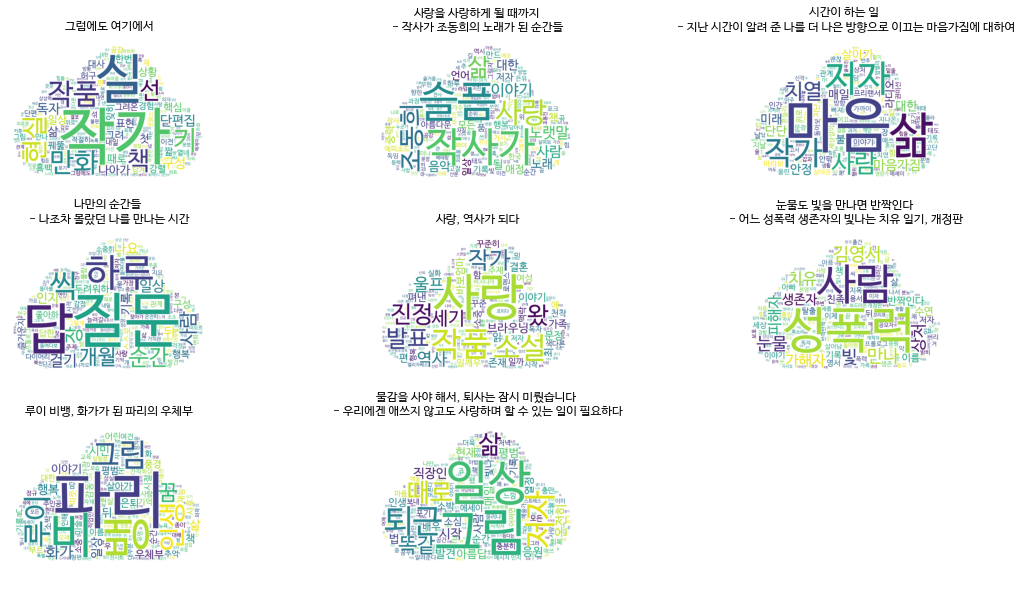

In [ ]:
# 1. 검색 --------------------------------------------------------------------------------------------
카테고리 = []
장르 = []
감성 = []
관심사 = []
성인 = []
장르no = []
감성no = []
관심사no = []
성인no = []
userid = []

userid질문 = input('회원이십니까? : 네 / 아니요\n')
if userid질문 == '네':
  userid.append(input('\n아이디를 입력해주세요 : \n'))
  성인질문 = input('\n성인입니까? : 네 / 아니요\n')
else:
  성인질문 = input('\n성인입니까? : 네 / 아니요\n')

if 성인질문 == '네':
    성인.append([True,False])
    카테고리.append(input("\n원하시는 분야를 입력해주세요 : \n소설 / 에세이 / 자기계발 / 시 / 희곡 / 선택없음\n").split())
    장르.append(input('\n책을 읽을 때 선호하는 장르가 있나요? : \n시대 / 역사 / 철학 / 로맨스 / 전쟁 / 미스터리 / 예술 / 판타지 / 자서전 / 동화 / 과학 / 무협 / 선택없음\n').split())
    장르no.append(input('\n원하지 않는 장르를 입력해주세요 : \n').split())
    감성.append(input('\n어떤 감성의 책을 원하세요? : \n고민 / 열정 / 도전 / 긍정 / 후회 / 행복 / 우울 / 위로 / 고통 / 자유 /\
                    \n희망 / 슬픔 / 열망 / 비극 / 불안 / 용기 / 절망 / 불행 / 유머 / 힐링 / 선택없음\n').split())
    감성no.append(input('\n원하지 않는 감성을 입력해주세요 : \n').split())
    관심사.append(input('\n요즘 관심있는 것이 무엇인가요? : \n리더십 / 시간 / 페미니즘 / 취업 / 진로 / 비즈니스 / 설득 / 건강 / 심리 /\
                    \n가족 / 관계 / 동물 / 사진 / 그림 / 여행 / 미술 / 영화 / 음악 / 음식 / 일기 / 자연 /\
                    \n종교 / 사랑 / 인간 / 생각 / 사회 / 인생 / 일상 / 친구 / 성공 / 청춘 / 정치 / 취미 / 스포츠 / 선택없음\n').split())
    관심사no.append(input('\n원하지 않는 관심사를 입력해주세요 : \n').split())
elif 성인질문 == '아니요':
    성인.append([False])
    카테고리.append(input("\n원하시는 분야를 입력해주세요 : \n소설 / 에세이 / 자기계발 / 시 / 희곡 / 선택없음\n").split())
    장르.append(input('\n책을 읽을 때 선호하는 장르가 있나요? : \n시대 / 역사 / 철학 / 로맨스 / 전쟁 / 미스터리 / 예술 / 판타지 / 자서전 / 동화 / 과학 / 무협 / 선택없음\n').split())
    장르no.append(input('\n원하지 않는 장르를 입력해주세요 : \n').split())
    감성.append(input('\n어떤 감성의 책을 원하세요? : \n고민 / 열정 / 도전 / 긍정 / 후회 / 행복 / 우울 / 위로 / 고통 / 자유 /\
                    \n희망 / 슬픔 / 열망 / 비극 / 불안 / 용기 / 절망 / 불행 / 유머 / 힐링 / 선택없음\n').split())
    감성no.append(input('\n원하지 않는 감성을 입력해주세요 : \n').split())
    관심사.append(input('\n요즘 관심있는 것이 무엇인가요? : \n리더십 / 시간 / 페미니즘 / 취업 / 진로 / 비즈니스 / 설득 / 건강 / 심리 /\
                    \n가족 / 관계 / 동물 / 사진 / 그림 / 여행 / 미술 / 영화 / 음악 / 음식 / 일기 / 자연 /\
                    \n종교 / 사랑 / 인간 / 생각 / 사회 / 인생 / 일상 / 친구 / 성공 / 청춘 / 정치 / 취미 / 스포츠 / 선택없음\n').split())
    관심사no.append(input('\n원하지 않는 관심사를 입력해주세요 : \n').split())
print()

select_list_and = []
for i in range(len(re)):
    if (re['adult'][i] in 성인[0]) & category(카테고리) & genresor(장르) & moodand(감성) & interestand(관심사)\
    & nogenresand(장르no) & nomoodand(감성no) & nointerestand(관심사no) :
        select_list_and.append(re.loc[i])
        
select_book_and = pd.DataFrame(select_list_and)

select_list_or = []
for i in range(len(re)):
    if (re['adult'][i] in 성인[0]) & category(카테고리) & genresor(장르) & moodor(감성) & interestor(관심사)\
    & nogenresand(장르no) & nomoodand(감성no) & nointerestand(관심사no):
        select_list_or.append(re.loc[i])
        
select_book_or = pd.DataFrame(select_list_or)

if len(select_book_and) >= 20:
    a = select_book_and
else:
    a = select_book_or

%time
# 2. 가중평점 --------------------------------------------------------------------------------------------

# 가중평점
# 상위 60%에 해당하는 rank를 최소 투표 횟수인 m으로 지정
C = re['rank_pred'].mean()
m = re['salesPoint'].quantile(0.6)

def weighted_score_average(record):
    v = record['salesPoint']
    R = record['rank_pred']
    
    return ( (v/(v+m)) * R ) + ( (m/(m+v)) * C )

# 기존 데이터에 가중평점 칼럼 추가
a['weighted_score'] = re.apply(weighted_score_average, axis=1)
a = a.sort_values('weighted_score', ascending = False)
a = a.head(100)


# 3-1. 협업필터링 --------------------------------------------------------------------------------------------

b = pd.merge(a, books_all, on = 'isbn')
ratings_matrix = b.pivot_table('review_rank', index='review_id', columns='title')


%time
# 경사하강법을 이용한 행렬 분해
P, Q = matrix_factorization(ratings_matrix.values, K=50, steps=300, learning_rate=0.01, r_lambda = 0.01)
# K=50 잠재요인, steps=200: 200번 반복 수행, learning rate: 학습률, r_lambda: L2 규제 계수

pred_matrix = np.dot(P, Q.T) # 행렬의 곱(내적)

ratings_pred_matrix = pd.DataFrame(data=pred_matrix, index= ratings_matrix.index,
                                   columns = ratings_matrix.columns)
ratings_matrix_T = ratings_pred_matrix.transpose()

# 도서들 간 코사인 유사도 산출
item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

# cosine_similarity() 로 반환된 넘파이 행렬을 도서명을 매핑하여 DataFrame으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_pred_matrix.columns,
                          columns=ratings_pred_matrix.columns)

sim_books = []

for i in range(3):
    try:
      sim_book = item_sim_df[a.loc[a.head(3).index[i]]['title']].sort_values(ascending=False)[0:3]
      sim_books.append(sim_book)
    except:
      pass
sim_books_1 = pd.DataFrame(sim_books)

col = sim_books_1.columns
sim_list = []
for i in col:
    for j in a.index:
        if a['title'][j] == i:
            sim_list.append(a.loc[j])
sim_list_df = pd.DataFrame(sim_list)

# sim_list_df : 협업필터링3-1 결과

# ---------------------------------------------------------------------------------------------------------------

# 3-2 userid 추천
# 사용자가 관람하지 않는 도서명 추출
try:   
  unseen_list = get_unseen_books(ratings_matrix, userid[0])
  # 잠재 요인 협업 필터링으로 도서 추천 
  recomm_books = recomm_book_by_userid(ratings_pred_matrix, userid[0], unseen_list, top_n=9)
  # 평점 데이타를 DataFrame으로 생성. 
  recomm_books = pd.DataFrame(data=recomm_books.values,index=recomm_books.index,columns=['pred_score'])
  recomm_books = recomm_books[recomm_books['pred_score'] > 1]

  cols2 = recomm_books.index

  recomm_list = []
  for i in cols2:
      for j in a.index:
          if a['title'][j] == i:
              recomm_list.append(a.loc[j])
  recomm_list_df = pd.DataFrame(recomm_list)

except:
  pass
# recomm_books : 협업필터링3-2 결과

# user 정보가 있으면 3-1 결과 output, 없으면 3-2 결과 output
if userid질문 == '아니요':
  recommend = sim_list_df
else: # userid질문 == '예'
  try:
    recommend = recomm_list_df
  except:
    recommend = sim_list_df

recommend

# ---------------------------------------------------------------------------------------------------------------
# 워드클라우드

word = pd.merge(recommend,book1, on='isbn')
word['text'] = word['text'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]',' ')
words_all = []
results = []

for i in word['text']:
    text = mecab.morphs(i)
    
    r=[]
    for te in text:
        r.append(te)
        words_all.append(te)
    rl = (" ".join(r)).strip() # 문장 하나 하나
    results.append(rl) # 모든 문장 append

wordclound = []
for se in results:
    result1 = []
    for w in se.split(' '):
      if w not in stopwords:
          result1.append(w)
    wordclound.append(result1)

gen_list = [] 
W, H = (100,50) 
font_path = 'NanumBarunGothic'
for clound in wordclound:
  mask = np.array(Image.open('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/cloud.png'))
  wc = WordCloud(font_path=font_path, background_color="white", width=W*10,height=H*10, mask=mask)
  c = Counter(clound) # 위에서 얻은 words를 처리하여 단어별 빈도수 형태의 딕셔너리 데이터를 구함
  gen = wc.generate_from_frequencies(c)
  gen_list.append(gen)

plt.figure(figsize = (W//6, H//6), facecolor = None)

for i in range(len(recommend)):
  plt.subplot(3, 3, i+1)  
  tit = word.loc[i]['title']
  if '-' in tit:
    tit_ = tit.split('-')
    tit = tit_[0]+'\n-'+tit_[1]
  plt.title((tit))
  plt.imshow(gen_list[i]) 
  plt.axis("off")
  plt.tight_layout(pad = 0)


word[['title','author','categoryName','genres','mood','interest']]


# 6. EDA

In [ ]:
# 한글 폰트 오류 해결
from matplotlib import font_manager, rc
font_path = "c:/Windows/Fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font',family=font_name)

In [ ]:
# colab 폰트 오류
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (23.5 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 156210 files and di

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54976 entries, 0 to 54975
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         54976 non-null  int64 
 1   title         54976 non-null  object
 2   author        54976 non-null  object
 3   pubDate       54976 non-null  object
 4   description   54976 non-null  object
 5   isbn13        54976 non-null  object
 6   categoryID    54976 non-null  int64 
 7   categoryName  54976 non-null  object
 8   salesPoint    54976 non-null  int64 
 9   adult         54976 non-null  bool  
 10  rank          54976 non-null  int64 
 11  fullDes       54976 non-null  object
 12  fullDes2      54976 non-null  object
 13  story         54976 non-null  object
 14  reviewrank    54976 non-null  int64 
 15  reviewtitle   54976 non-null  object
 16  review_w      54976 non-null  object
 17  text          54976 non-null  object
 18  keyword       54976 non-null  object
dtypes: b

In [ ]:
df3.describe()

,index,categoryID,salesPoint,rank,reviewrank
count,54976.000000,54976.000000,54976.000000,54976.000000,54976.000000
mean,36767.034142,55341.671711,1113.451288,5.810081,5.574542
std,19941.703509,16709.482097,6315.607985,4.272143,4.337982
min,0.000000,2944.000000,0.000000,0.000000,0.000000
25%,20003.750000,51040.000000,54.000000,0.000000,0.000000
50%,36218.500000,51167.000000,158.000000,8.000000,8.000000
75%,54073.250000,51371.000000,575.000000,9.000000,10.000000
max,71638.000000,190716.000000,379054.000000,10.000000,10.000000


- 성인 도서 비율

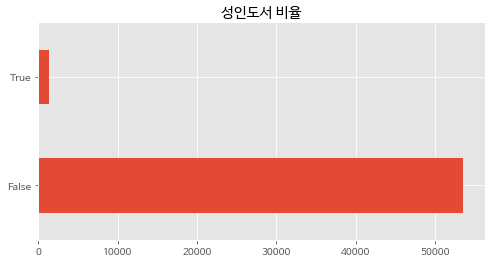

In [ ]:
plt.style.use('ggplot')

df3['adult'].value_counts().plot(kind = 'barh', figsize = (8,4))
plt.title('성인도서 비율')
plt.show()

- 카테고리 비율

In [ ]:
re = pd.read_pickle('/content/drive/MyDrive/도서추천시스템_2/검색 및 추천시스템/recommend_cat_new.pkl')

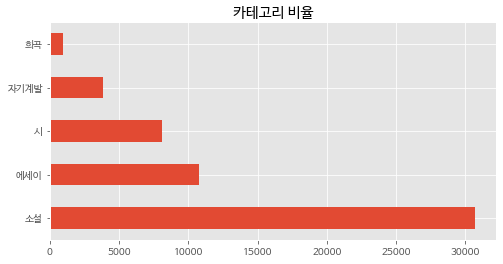

In [ ]:
re['categoryName'].value_counts().plot(kind = 'barh', figsize = (8,4))
plt.title('카테고리 비율')
plt.show()

In [ ]:
df3['categoryName'].value_counts()

소설/시/희곡    40068
에세이        10951
자기계발        3957
Name: categoryName, dtype: int64

- rank 비율

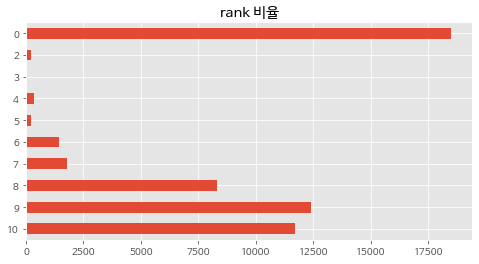

In [ ]:
df3['rank'].value_counts().sort_index(ascending = False).plot(kind = 'barh', figsize = (8,4))
plt.title('rank 비율')
plt.show()

- 키워드 EDA

In [ ]:
# df2에서 각 관심사 키워드 나온 횟수
# df2 : total_keywords_30.pkl

for srch in key_list:
    for i in range(len(df2)):
        if df2[:]['keyword'][i] == srch:
            print(srch, df2.iloc[(i,1)])
            break
        else:
            pass

시대 5934
역사 4092
철학 993
로맨스 2201
전쟁 1824
미스터리 1389
예술 1516
판타지 1455
자서전 183
동화 767
과학 779
무협 164
고민 1837
열정 822
희곡 613
가족 2833
관계 2942
동물 688
사진 1364
그림 2167
여행 2169
미술 249
영화 2237
음악 751
음식 499
인생 6363
일상 5233
친구 3077
성공 1882
청춘 1049
정치 1091
취미 185
스포츠 90
일기 859
자연 2429
종교 652
사랑 14067
인간 8930
생각 8641
사회 5870
도전 589
긍정 572
후회 366
행복 3784
우울 389
위로 1802
고통 1764
자유 1682
희망 1567
슬픔 1294
열망 199
비극 1108
불안 1058
용기 1005
절망 902
불행 547
유머 555
힐링 214
리더십 187
시간 7149
페미니즘 160
취업 234
진로 79
비즈니스 207
설득 139
건강 506
심리 1135
